In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.catboost

from scipy import stats

from src.utils import detect_outliers_iqr, analyze_column, calculate_correlations
from src.train import ModelTrainer
from src.anomaly_detection import (
    remove_univariate_outliers,
    remove_price_discrepancy_outliers,
    remove_feature_outliers_isoforest,
)
from src.preprocessing import (
    create_detailed_date_features,
    create_missingness_flags,
    categorize_transactions,
    add_district_column,
)
from src.model_export import ModelExporter

This notebook examines the dataset of Dubai Land Department. It consists of two parts:

* Exploratory Data Analysis

* Machine Learning Modeling

# Exploratory data analysis

The purpose of this analysis is to explore the data in the existing dataset and prepare it for further machine modelling. The scope of the research is the residential real estate in Dubai

## First look at data

In [7]:
df = pd.read_csv("/Users/vitalyboldyrev/real_estate_uae/Transactions.csv")

In [8]:
df.shape[0], df.shape[1]

(1424588, 46)

In [9]:
df.duplicated().sum()

0

In [10]:
df.head()

,transaction_id,procedure_id,trans_group_id,trans_group_ar,trans_group_en,procedure_name_ar,procedure_name_en,instance_date,property_type_id,property_type_ar,...,rooms_en,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
0,1-11-2024-10138,11,1,مبايعات,Sales,بيع,Sell,19-03-2024,4,فيلا,...,NaN,0,1305.29,5769000.0,4419.71,NaN,NaN,8.0,1.0,0.0
1,3-9-2002-39,9,3,هبات,Gifts,هبه,Grant,25-03-2002,1,أرض,...,NaN,0,1466.94,1105300.0,753.47,NaN,NaN,1.0,1.0,0.0
2,1-11-2016-12930,11,1,مبايعات,Sales,بيع,Sell,02-11-2016,4,فيلا,...,NaN,0,390.00,2089900.0,5358.72,NaN,NaN,1.0,1.0,0.0
3,1-11-2005-300028,11,1,مبايعات,Sales,بيع,Sell,28-02-2005,4,فيلا,...,NaN,0,396.09,511612.0,1291.66,NaN,NaN,1.0,1.0,0.0
4,1-11-2010-17709,11,1,مبايعات,Sales,بيع,Sell,09-12-2010,2,مبنى,...,NaN,0,559.18,5700000.0,10193.50,NaN,NaN,1.0,1.0,0.0


In [11]:
df.sample(5)

,transaction_id,procedure_id,trans_group_id,trans_group_ar,trans_group_en,procedure_name_ar,procedure_name_en,instance_date,property_type_id,property_type_ar,...,rooms_en,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
657449,1-41-2009-121,41,1,مبايعات,Sales,بيع مبدئى,Delayed Sell,12-01-2009,1,أرض,...,NaN,0,804.90,1793436.0,2228.15,NaN,NaN,1.0,1.0,0.0
74276,2-13-2012-2357,13,2,رهون,Mortgages,تسجيل رهن,Mortgage Registration,19-06-2012,4,فيلا,...,NaN,0,86281.25,132120000.0,1531.27,NaN,NaN,1.0,1.0,0.0
570369,1-102-2024-92954,102,1,مبايعات,Sales,بيع - تسجيل مبدئى,Sell - Pre registration,04-11-2024,4,فيلا,...,4 B/R,0,367.94,4453990.0,12105.21,NaN,NaN,1.0,1.0,0.0
898357,1-11-2023-11227,11,1,مبايعات,Sales,بيع,Sell,24-04-2023,3,وحدة,...,Studio,1,37.31,800000.0,21441.97,NaN,NaN,1.0,1.0,0.0
1309271,2-13-2015-997,13,2,رهون,Mortgages,تسجيل رهن,Mortgage Registration,09-02-2015,4,فيلا,...,NaN,0,582.69,3525000.0,6049.53,NaN,NaN,2.0,1.0,0.0


In [12]:
df.dtypes.value_counts()

object     30
float64    10
int64       6
Name: count, dtype: int64

In [13]:
df.describe()

,procedure_id,trans_group_id,property_type_id,property_sub_type_id,reg_type_id,area_id,project_number,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
count,1.424588e+06,1.424588e+06,1.424588e+06,1.122476e+06,1.424588e+06,1.424588e+06,994904.000000,1.424588e+06,1.424588e+06,1.424588e+06,1.424588e+06,3.556300e+04,3.556300e+04,1.423659e+06,1.423659e+06,1.423659e+06
mean,5.960180e+01,1.277517e+00,2.992916e+00,5.375338e+01,6.765514e-01,4.096257e+02,1644.930372,6.455593e-01,1.349967e+03,3.935244e+06,1.458003e+04,1.459977e+06,2.062138e+04,1.254596e+00,1.184060e+00,1.202865e-01
std,8.817324e+01,5.240122e-01,7.483933e-01,2.059326e+01,4.677924e-01,6.882199e+01,859.964916,4.783437e-01,3.070304e+05,6.453138e+07,1.283728e+05,2.532592e+06,2.881686e+05,3.017364e+00,5.021585e-01,5.498772e-01
min,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,2.290000e+02,2.000000,0.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.000000e+00,3.000000e+00,6.000000e+01,0.000000e+00,3.500000e+02,1050.000000,0.000000e+00,7.034000e+01,7.300000e+05,6.931980e+03,6.000000e+05,5.010305e+03,1.000000e+00,1.000000e+00,0.000000e+00
50%,3.900000e+01,1.000000e+00,3.000000e+00,6.000000e+01,1.000000e+00,4.120000e+02,1672.000000,1.000000e+00,1.159300e+02,1.326700e+06,1.066545e+04,1.020000e+06,7.184720e+03,1.000000e+00,1.000000e+00,0.000000e+00
75%,1.020000e+02,1.000000e+00,3.000000e+00,6.000000e+01,1.000000e+00,4.620000e+02,2274.000000,1.000000e+00,2.306800e+02,2.458002e+06,1.630259e+04,1.800000e+06,1.010873e+04,1.000000e+00,1.000000e+00,0.000000e+00
max,8.610000e+02,3.000000e+00,4.000000e+00,1.120000e+02,1.000000e+00,5.310000e+02,3580.000000,1.000000e+00,3.421034e+08,1.378694e+10,8.125000e+07,2.620800e+08,1.109416e+07,7.030000e+02,5.100000e+01,1.700000e+01


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424588 entries, 0 to 1424587
Data columns (total 46 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   transaction_id        1424588 non-null  object 
 1   procedure_id          1424588 non-null  int64  
 2   trans_group_id        1424588 non-null  int64  
 3   trans_group_ar        1424588 non-null  object 
 4   trans_group_en        1424588 non-null  object 
 5   procedure_name_ar     1424588 non-null  object 
 6   procedure_name_en     1424588 non-null  object 
 7   instance_date         1424588 non-null  object 
 8   property_type_id      1424588 non-null  int64  
 9   property_type_ar      1424588 non-null  object 
 10  property_type_en      1424588 non-null  object 
 11  property_sub_type_id  1122476 non-null  float64
 12  property_sub_type_ar  1122476 non-null  object 
 13  property_sub_type_en  1122476 non-null  object 
 14  property_usage_ar     1424588 non-

In [15]:
pd.DataFrame(
    {"Missing": df.isnull().sum(), "% Missing": (df.isnull().mean() * 100).round(2)}
).sort_values(by="Missing", ascending=False)

,Missing,% Missing
meter_rent_price,1389025,97.50
rent_value,1389025,97.50
project_number,429684,30.16
project_name_ar,429684,30.16
project_name_en,429684,30.16
building_name_ar,429143,30.12
building_name_en,428702,30.09
nearest_mall_en,399536,28.05
nearest_mall_ar,399536,28.05
nearest_metro_en,392802,27.57


In [16]:
pd.DataFrame(
    {"Unique": df.nunique(), "% Unique": (df.nunique() / len(df) * 100).round(1)}
).sort_values(by="Unique", ascending=False)

,Unique,% Unique
transaction_id,1424588,100.0
meter_sale_price,796367,55.9
actual_worth,322151,22.6
procedure_area,88472,6.2
meter_rent_price,29076,2.0
rent_value,15365,1.1
instance_date,6350,0.4
building_name_en,4076,0.3
building_name_ar,4074,0.3
project_number,2704,0.2


The dataset has almost 1.5 million observations (1 row = 1 real estate related transaction) and 46 features, most of them categorical. It makes sense to examine these features more closely. There are also features with meanings in Arabic, they duplicate the features in English. In fact, they are of little value and can be discarded.

There are missing values in the meaning of a number of features. The vast majority are in signs that denote mortgage real estate. Given the number of NaNs (apparently it means that other property items were not purchased with a mortgage), options for removing these features may be considered in the future.

## Excluding columns with arabic names

In [19]:
df.columns[df.columns.str.contains("_ar")]

Index(['trans_group_ar', 'procedure_name_ar', 'property_type_ar',
       'property_sub_type_ar', 'property_usage_ar', 'reg_type_ar',
       'area_name_ar', 'building_name_ar', 'project_name_ar',
       'master_project_ar', 'nearest_landmark_ar', 'nearest_metro_ar',
       'nearest_mall_ar', 'rooms_ar', 'procedure_area'],
      dtype='object')

In [20]:
arabic_cols = [
    "trans_group_ar",
    "procedure_name_ar",
    "property_type_ar",
    "property_sub_type_ar",
    "property_usage_ar",
    "reg_type_ar",
    "area_name_ar",
    "building_name_ar",
    "project_name_ar",
    "master_project_ar",
    "nearest_landmark_ar",
    "nearest_metro_ar",
    "nearest_mall_ar",
    "rooms_ar",
]

In [21]:
clean_df = df.copy()

In [22]:
clean_df = clean_df.drop(arabic_cols, axis=1)

In [23]:
clean_df.describe()

,procedure_id,trans_group_id,property_type_id,property_sub_type_id,reg_type_id,area_id,project_number,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3
count,1.424588e+06,1.424588e+06,1.424588e+06,1.122476e+06,1.424588e+06,1.424588e+06,994904.000000,1.424588e+06,1.424588e+06,1.424588e+06,1.424588e+06,3.556300e+04,3.556300e+04,1.423659e+06,1.423659e+06,1.423659e+06
mean,5.960180e+01,1.277517e+00,2.992916e+00,5.375338e+01,6.765514e-01,4.096257e+02,1644.930372,6.455593e-01,1.349967e+03,3.935244e+06,1.458003e+04,1.459977e+06,2.062138e+04,1.254596e+00,1.184060e+00,1.202865e-01
std,8.817324e+01,5.240122e-01,7.483933e-01,2.059326e+01,4.677924e-01,6.882199e+01,859.964916,4.783437e-01,3.070304e+05,6.453138e+07,1.283728e+05,2.532592e+06,2.881686e+05,3.017364e+00,5.021585e-01,5.498772e-01
min,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,2.290000e+02,2.000000,0.000000e+00,1.000000e-02,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.000000e+00,3.000000e+00,6.000000e+01,0.000000e+00,3.500000e+02,1050.000000,0.000000e+00,7.034000e+01,7.300000e+05,6.931980e+03,6.000000e+05,5.010305e+03,1.000000e+00,1.000000e+00,0.000000e+00
50%,3.900000e+01,1.000000e+00,3.000000e+00,6.000000e+01,1.000000e+00,4.120000e+02,1672.000000,1.000000e+00,1.159300e+02,1.326700e+06,1.066545e+04,1.020000e+06,7.184720e+03,1.000000e+00,1.000000e+00,0.000000e+00
75%,1.020000e+02,1.000000e+00,3.000000e+00,6.000000e+01,1.000000e+00,4.620000e+02,2274.000000,1.000000e+00,2.306800e+02,2.458002e+06,1.630259e+04,1.800000e+06,1.010873e+04,1.000000e+00,1.000000e+00,0.000000e+00
max,8.610000e+02,3.000000e+00,4.000000e+00,1.120000e+02,1.000000e+00,5.310000e+02,3580.000000,1.000000e+00,3.421034e+08,1.378694e+10,8.125000e+07,2.620800e+08,1.109416e+07,7.030000e+02,5.100000e+01,1.700000e+01


To make these and future changes, it would be appropriate to create a copy of the dataframe in which to make the changes. 

## Deleting data outside the scoop

property_usage_en

Descriptive statistics:
count         1424588
unique             11
top       Residential
freq          1199168
Name: property_usage_en, dtype: object

 Number of missing values: 0

Unique values and its frequency:
property_usage_en
Residential                              1199168
Commercial                                145807
Hospitality                                40228
Residential / Commercial                   14189
Other                                      13681
Multi-Use                                   5701
Industrial                                  3507
Agricultural                                1100
Industrial / Commercial                      661
Storage                                      482
Industrial / Commercial / Residential         64
Name: count, dtype: int64


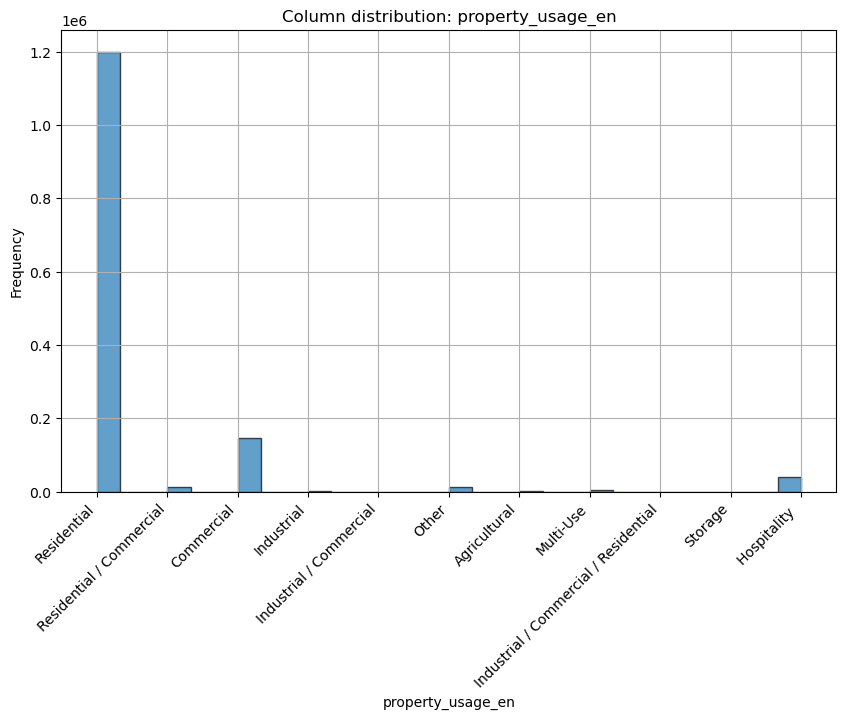

In [26]:
analyze_column(clean_df, "property_usage_en")

In [27]:
values_to_keep = ["Residential"]

In [28]:
clean_df = clean_df[clean_df["property_usage_en"].isin(values_to_keep)]

In [29]:
clean_df = clean_df.drop("property_usage_en", axis=1)

Since only residential properties are considered in this study, it is necessary to keep only these in the dataset (properties with multiple ownership types, such as residential/industrial/commercial, are also not relevant to the scope of the study).

## Train/test split

In [32]:
clean_df["instance_date"] = pd.to_datetime(
    clean_df["instance_date"], format="mixed", errors="coerce"
)

In [33]:
clean_df["instance_date"].isna().sum()

3

instance_date

Descriptive statistics:
count                          1199165
mean     2018-07-20 06:12:59.276246272
min                1975-01-01 00:00:00
25%                2013-12-25 00:00:00
50%                2020-02-17 00:00:00
75%                2023-09-05 00:00:00
max                2025-12-03 00:00:00
Name: instance_date, dtype: object

 Number of missing values: 3

Unique values and its frequency:
instance_date
2023-11-09    2589
2010-03-03    2126
2009-10-26    2097
2024-12-30    1719
2024-07-16    1704
              ... 
1997-02-27       1
1997-06-18       1
1998-05-20       1
1995-03-01       1
1994-01-12       1
Name: count, Length: 5921, dtype: int64


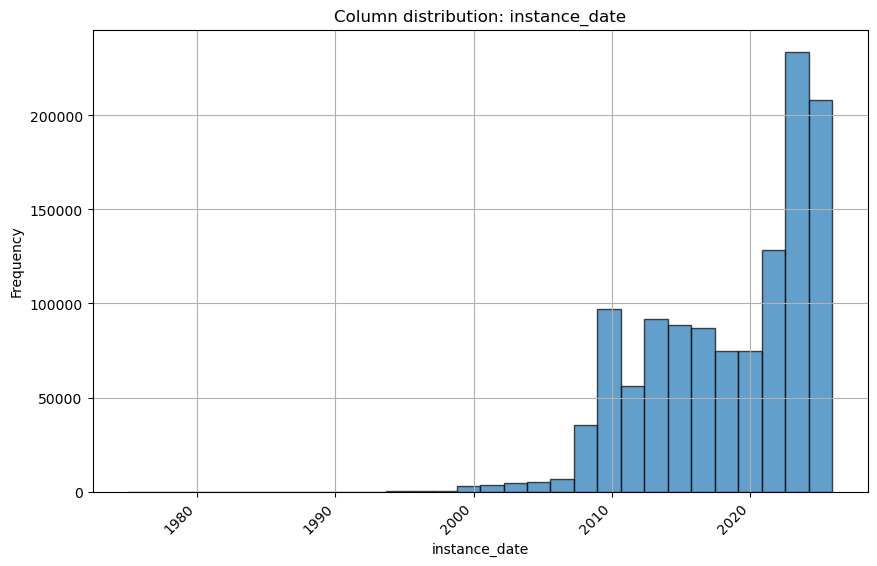

In [34]:
analyze_column(clean_df, "instance_date")

In [35]:
clean_df = clean_df.dropna(subset=["instance_date"])

In [36]:
clean_df = clean_df.rename(columns={"instance_date": "date"})

In [37]:
clean_df = clean_df.sort_values("date").reset_index(drop=True)

In [38]:
clean_df["year"] = clean_df.date.dt.year

In [39]:
year_counts = clean_df["year"].value_counts().sort_index(ascending=False)
year_counts

year
2025     49485
2024    198851
2023    143119
2022     99634
2021     71348
2020     42476
2019     45653
2018     41579
2017     52342
2016     48664
2015     47744
2014     57519
2013     64119
2012     36802
2011     33018
2010     40600
2009     65342
2008     26967
2007     12415
2006      3608
2005      2822
2004      3155
2003      2649
2002      2621
2001      2031
2000      1551
1999      2116
1998       585
1997        97
1996        44
1995        61
1994        43
1993        25
1992        16
1991         6
1990        11
1989        14
1988         5
1987         4
1986         4
1985         3
1984         5
1983         1
1982         2
1981         1
1980         2
1978         1
1977         3
1976         1
1975         1
Name: count, dtype: int64

In [40]:
yearly_target = clean_df.groupby("year")["actual_worth"].mean()
yearly_target

year
1975    5.000000e+04
1976    1.250000e+05
1977    1.474000e+06
1978    5.000000e+05
1980    9.214145e+05
1981    1.000000e+05
1982    6.857500e+05
1983    7.000000e+05
1984    5.100000e+05
1985    3.527897e+05
1986    4.137500e+05
1987    4.546895e+05
1988    6.929446e+05
1989    6.649557e+06
1990    2.108328e+06
1991    9.166667e+05
1992    1.560112e+06
1993    2.446738e+06
1994    2.555071e+06
1995    1.520028e+06
1996    2.601871e+06
1997    2.094015e+06
1998    1.595533e+06
1999    8.970640e+05
2000    1.131047e+06
2001    1.311232e+06
2002    1.426471e+06
2003    1.748320e+06
2004    2.554155e+06
2005    3.216955e+06
2006    3.932781e+06
2007    3.375769e+06
2008    2.862802e+06
2009    1.393750e+06
2010    1.844405e+06
2011    2.117117e+06
2012    2.025068e+06
2013    2.116029e+06
2014    2.200546e+06
2015    2.447712e+06
2016    2.361352e+06
2017    2.279545e+06
2018    2.193578e+06
2019    2.370969e+06
2020    2.036838e+06
2021    2.330565e+06
2022    3.130378e+06
2023    

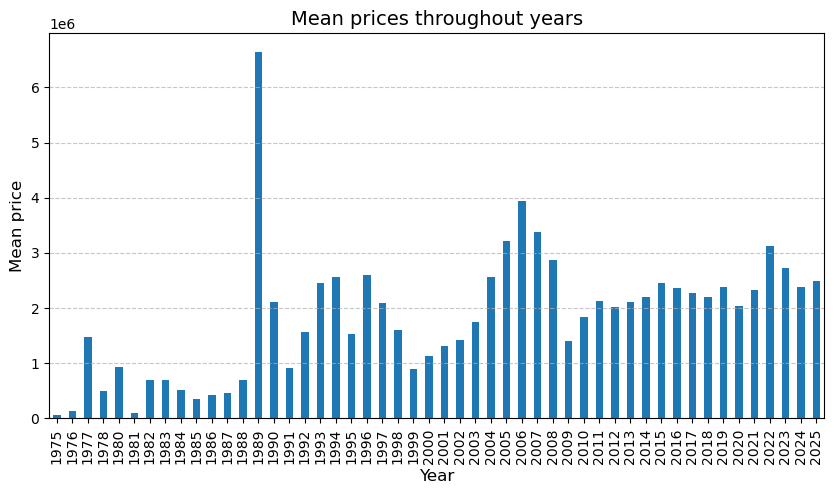

In [41]:
plt.figure(figsize=(10, 5))
yearly_target.plot(kind="bar")
plt.title("Mean prices throughout years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean price", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("fig1.png")
plt.show()

Most of the transactions were made in recent years. It is noteworthy that from 2009 to 2021, the number of transactions was at about the same level, with a surge occurring after 2022.

In [43]:
clean_df = clean_df[clean_df["date"] >= pd.to_datetime("2022-01-01")]
cutoff_idx = int(len(clean_df) * (1 - 0.2))

train_df = clean_df.iloc[:cutoff_idx].copy()
test_df = clean_df.iloc[cutoff_idx:].copy()

In [44]:
train_year = train_df.groupby("year")["actual_worth"].mean()

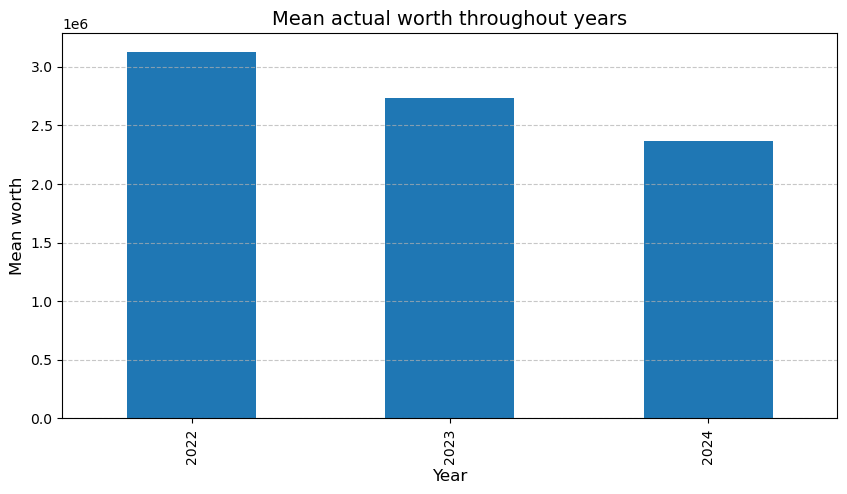

In [45]:
plt.figure(figsize=(10, 5))
train_year.plot(kind="bar")
plt.title("Mean actual worth throughout years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean worth", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [46]:
train_df.shape

(392871, 32)

In [47]:
test_df.shape

(98218, 32)

In the main body of the paper (in Section 1.1), much attention was paid to the changing real estate market in the post-COVID era. In this regard, it seems appropriate to consider only those properties that have been sold since the beginning of 2022 - thus, this study will examine the Dubai real estate market over a period of more than three years. 

Since the data are date and time bound, it makes sense to split the dataframe into a train and a test by time feature - leave 20% of the data for the test and include only the most recent observations (from October 2024 to March 2025). 

## Target feature selection

Since the target variable of the study is the price of real estate, and in this dataframe there are two features that are prices (total price and price per square meter), it makes sense to take a closer look at these features and choose one of them as the target variable.

In [51]:
train_df.actual_worth.describe()
# A large difference between the mean and median indicates the possible presence of outliers

count    3.928710e+05
mean     2.692756e+06
std      6.306963e+07
min      1.000000e+00
25%      7.900000e+05
50%      1.428810e+06
75%      2.500000e+06
max      1.378694e+10
Name: actual_worth, dtype: float64

In [52]:
detect_outliers_iqr(train_df, "actual_worth", weight=1.5)

Q1: 790000.00, Q3: 2500000.00, IQR: 1710000.00
Lower bound: -1775000.00
Upper bound: 5065000.00
Found 25326 anomalies.


Index([ 708076,  708084,  708086,  708095,  708099,  708103,  708125,  708135,
        708137,  708138,
       ...
       1100828, 1100840, 1100851, 1100870, 1100872, 1100888, 1100915, 1100919,
       1100920, 1100930],
      dtype='int64', length=25326)

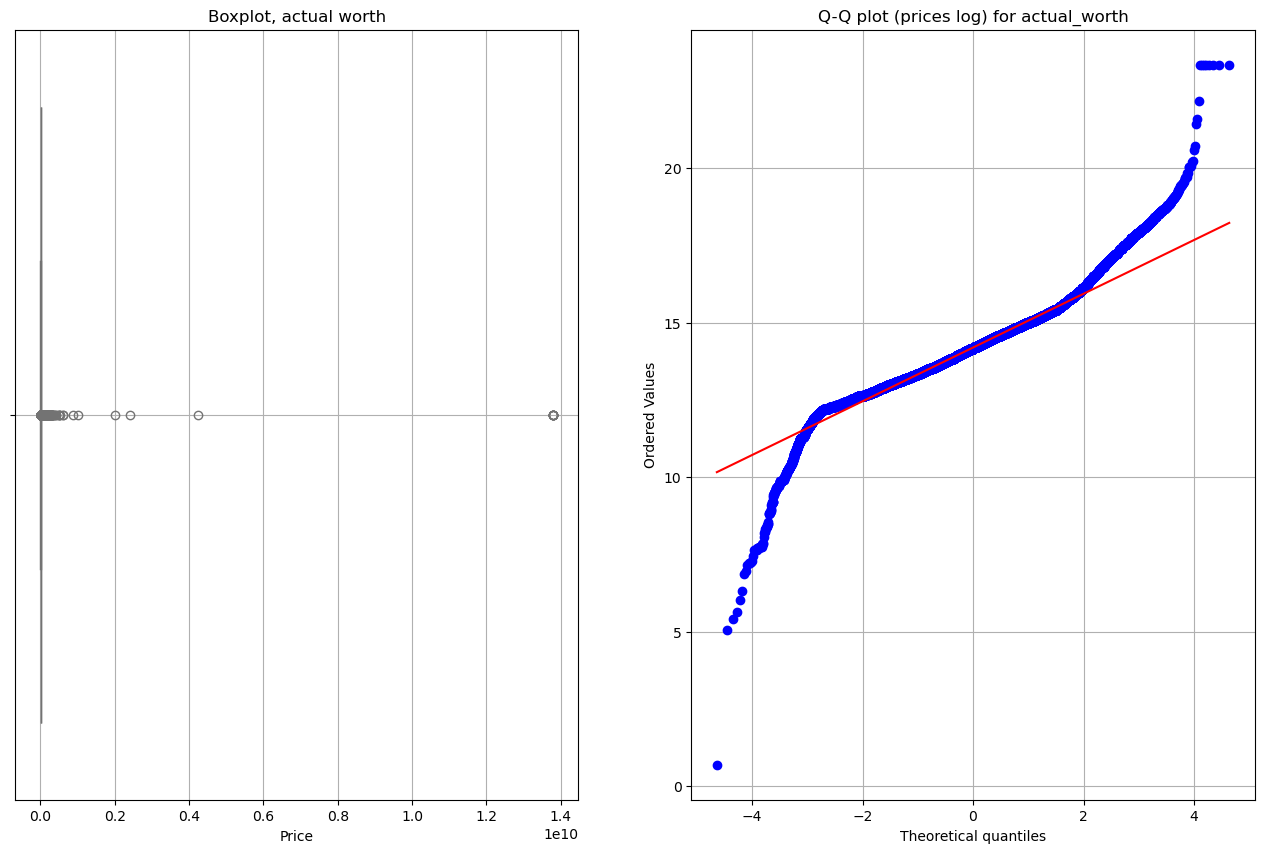

In [53]:
plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.boxplot(x=train_df["actual_worth"], color="lightgreen")
plt.title("Boxplot, actual worth")
plt.xlabel("Price")
plt.grid(True)

plt.subplot(1, 2, 2)
prices = np.log1p(train_df["actual_worth"].dropna())
stats.probplot(prices, dist="norm", plot=plt)
plt.title("Q-Q plot (prices log) for actual_worth")
plt.grid(True)
plt.savefig("fig2.png")
plt.show()

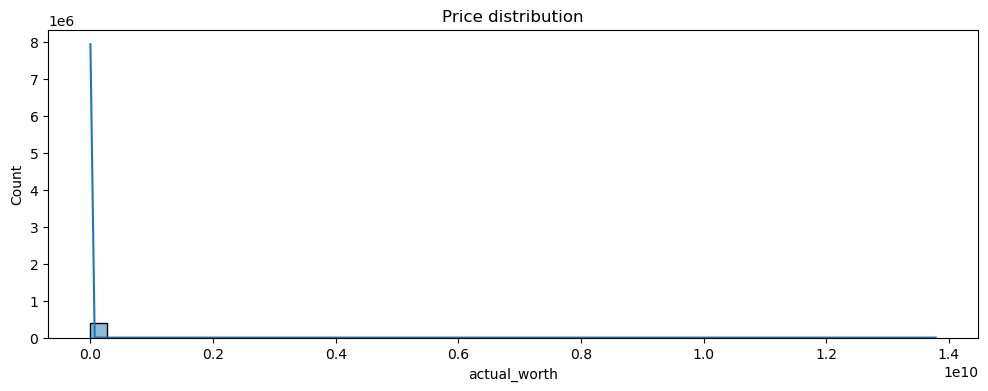

In [54]:
plt.figure(figsize=(12, 4))
sns.histplot(train_df["actual_worth"], bins=50, kde=True)
plt.title("Price distribution");

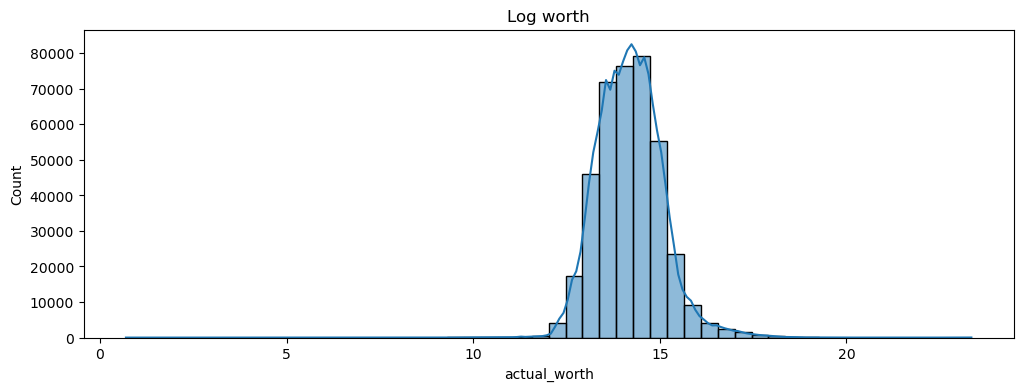

In [55]:
plt.figure(figsize=(12, 4))
sns.histplot(np.log1p(train_df["actual_worth"]), bins=50, kde=True)
plt.title("Log worth")
plt.show()

In [56]:
Q1 = train_df["actual_worth"].quantile(0.25)
Q3 = train_df["actual_worth"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = train_df[
    (train_df["actual_worth"] < lower_bound) | (train_df["actual_worth"] > upper_bound)
]

In [57]:
outliers_iqr.sort_values("actual_worth", ascending=False)

,transaction_id,procedure_id,trans_group_id,trans_group_en,procedure_name_en,date,property_type_id,property_type_en,property_sub_type_id,property_sub_type_en,...,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,year
756186,2-49-2022-50,49,2,Mortgages,Portfolio Mortgage Modification,2022-07-11,1,Land,NaN,NaN,...,0,265265.05,1.378694e+10,51974.19,NaN,NaN,1.0,1.0,0.0,2022
778949,2-49-2022-37,49,2,Mortgages,Portfolio Mortgage Modification,2022-09-27,1,Land,NaN,NaN,...,0,3627.12,1.378694e+10,3801069.84,NaN,NaN,60.0,1.0,0.0,2022
895278,2-49-2023-71,49,2,Mortgages,Portfolio Mortgage Modification,2023-08-28,1,Land,NaN,NaN,...,0,3627.12,1.378694e+10,3801069.84,NaN,NaN,84.0,1.0,0.0,2023
807757,2-49-2023-13,49,2,Mortgages,Portfolio Mortgage Modification,2023-01-02,1,Land,NaN,NaN,...,0,3627.12,1.378694e+10,3801069.84,NaN,NaN,59.0,1.0,0.0,2023
919950,2-49-2023-92,49,2,Mortgages,Portfolio Mortgage Modification,2023-10-24,1,Land,NaN,NaN,...,0,3627.12,1.378694e+10,3801069.84,NaN,NaN,84.0,1.0,0.0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061744,1-102-2024-14702,102,1,Sales,Sell - Pre registration,2024-08-03,3,Unit,60.0,Flat,...,1,232.86,5.065888e+06,21755.08,NaN,NaN,1.0,1.0,0.0,2024
821380,1-102-2023-58292,102,1,Sales,Sell - Pre registration,2023-02-11,3,Unit,60.0,Flat,...,1,232.87,5.065888e+06,21754.15,NaN,NaN,1.0,1.0,0.0,2023
960568,1-102-2024-4104,102,1,Sales,Sell - Pre registration,2024-01-22,4,Villa,4.0,Villa,...,0,204.13,5.065620e+06,24815.66,NaN,NaN,1.0,1.0,0.0,2024
926904,1-102-2023-45757,102,1,Sales,Sell - Pre registration,2023-11-09,4,Villa,4.0,Villa,...,0,288.00,5.065401e+06,17588.20,NaN,NaN,1.0,1.0,0.0,2023


In [58]:
sample = train_df["actual_worth"].sample(min(5000, len(train_df)), random_state=42)
stat, p = stats.shapiro(sample)
print(f"\nShapiro-Wilk normality test: p-value = {p:.4f}")
if p > 0.05:
    print("Distribution does not differ significantly from normal (p > 0.05)")
else:
    print("Distribution differs significantly from normal (p <= 0.05)")


Shapiro-Wilk normality test: p-value = 0.0000
Distribution differs significantly from normal (p <= 0.05)


In [59]:
train_df.meter_sale_price.describe()

count    3.928710e+05
mean     1.618904e+04
std      1.528010e+05
min      2.000000e-02
25%      9.227645e+03
50%      1.380158e+04
75%      2.040988e+04
max      8.125000e+07
Name: meter_sale_price, dtype: float64

In [60]:
detect_outliers_iqr(train_df, "meter_sale_price", weight=1.5)

Q1: 9227.65, Q3: 20409.88, IQR: 11182.24
Lower bound: -7545.71
Upper bound: 37183.23
Found 11254 anomalies.


Index([ 708156,  708199,  708209,  708294,  708317,  708367,  708408,  708422,
        708448,  708533,
       ...
       1100615, 1100632, 1100675, 1100690, 1100703, 1100725, 1100729, 1100808,
       1100870, 1100920],
      dtype='int64', length=11254)

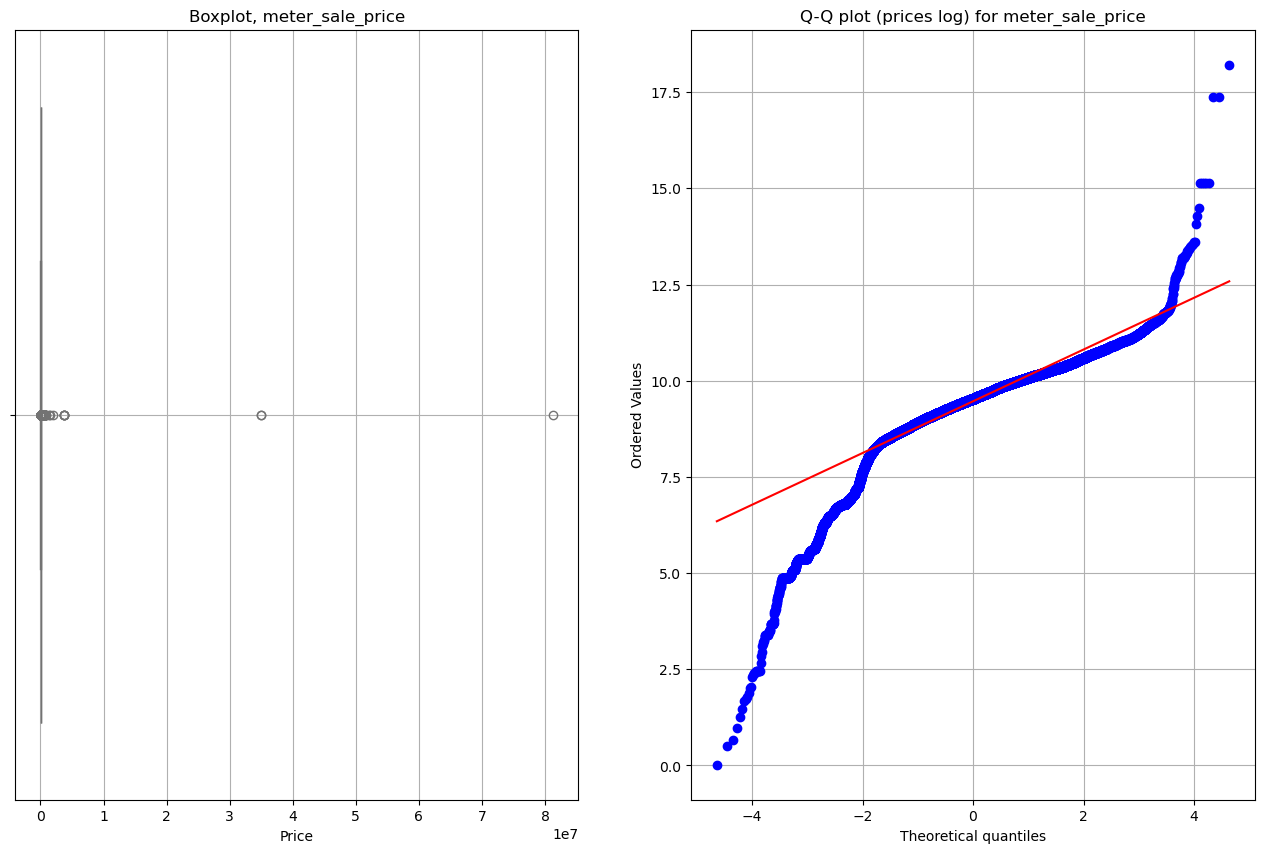

In [61]:
plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.boxplot(x=train_df["meter_sale_price"], color="lightgreen")
plt.title("Boxplot, meter_sale_price")
plt.xlabel("Price")
plt.grid(True)

plt.subplot(1, 2, 2)
prices = np.log1p(train_df["meter_sale_price"].dropna())
stats.probplot(prices, dist="norm", plot=plt)
plt.title("Q-Q plot (prices log) for meter_sale_price")
plt.grid(True)
plt.savefig("fig3.png")
plt.show()

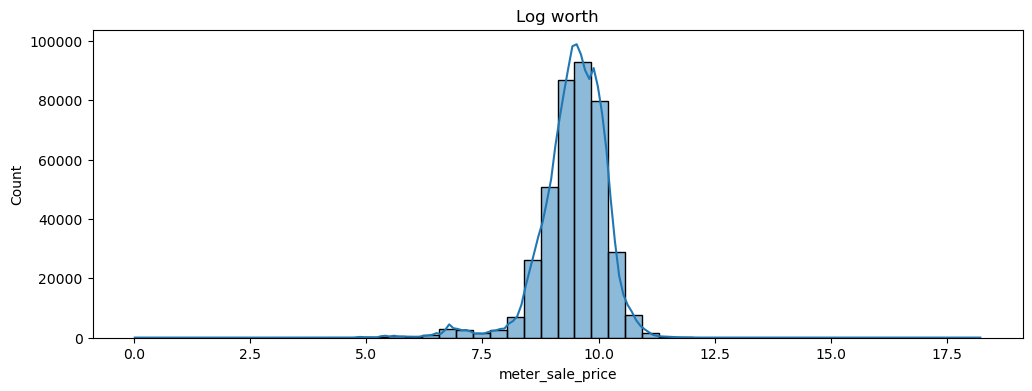

In [62]:
plt.figure(figsize=(12, 4))
sns.histplot(np.log1p(train_df["meter_sale_price"]), bins=50, kde=True)
plt.title("Log worth")
plt.show()

In [63]:
Q1 = train_df["meter_sale_price"].quantile(0.25)
Q3 = train_df["meter_sale_price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = train_df[
    (train_df["meter_sale_price"] < lower_bound)
    | (train_df["meter_sale_price"] > upper_bound)
]

In [64]:
outliers_iqr.sort_values("meter_sale_price", ascending=False)

,transaction_id,procedure_id,trans_group_id,trans_group_en,procedure_name_en,date,property_type_id,property_type_en,property_sub_type_id,property_sub_type_en,...,has_parking,procedure_area,actual_worth,meter_sale_price,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,year
962819,1-41-2024-1882,41,1,Sales,Delayed Sell,2024-01-25,3,Unit,60.0,Flat,...,1,0.01,8.125000e+05,81250000.00,NaN,NaN,1.0,1.0,0.0,2024
711089,2-43-2022-147,43,2,Mortgages,Portfolio Mortgage Registration,2022-01-11,1,Land,NaN,NaN,...,0,393.96,1.378694e+10,34995777.30,NaN,NaN,330.0,1.0,0.0,2022
717256,2-43-2022-148,43,2,Mortgages,Portfolio Mortgage Registration,2022-02-11,1,Land,NaN,NaN,...,0,393.96,1.378694e+10,34995777.30,NaN,NaN,330.0,1.0,0.0,2022
895278,2-49-2023-71,49,2,Mortgages,Portfolio Mortgage Modification,2023-08-28,1,Land,NaN,NaN,...,0,3627.12,1.378694e+10,3801069.84,NaN,NaN,84.0,1.0,0.0,2023
807757,2-49-2023-13,49,2,Mortgages,Portfolio Mortgage Modification,2023-01-02,1,Land,NaN,NaN,...,0,3627.12,1.378694e+10,3801069.84,NaN,NaN,59.0,1.0,0.0,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937121,1-102-2023-63284,102,1,Sales,Sell - Pre registration,2023-11-29,3,Unit,60.0,Flat,...,1,142.60,5.303183e+06,37189.22,NaN,NaN,1.0,1.0,0.0,2023
1022053,1-102-2024-30719,102,1,Sales,Sell - Pre registration,2024-05-22,3,Unit,60.0,Flat,...,1,104.79,3.897000e+06,37188.66,NaN,NaN,1.0,1.0,0.0,2024
894914,1-102-2023-41831,102,1,Sales,Sell - Pre registration,2023-08-25,3,Unit,60.0,Flat,...,1,186.30,6.928000e+06,37187.33,NaN,NaN,1.0,1.0,0.0,2023
860841,1-102-2023-25770,102,1,Sales,Sell - Pre registration,2023-05-31,3,Unit,60.0,Flat,...,1,118.81,4.418000e+06,37185.42,NaN,NaN,1.0,2.0,0.0,2023


In [65]:
sample = train_df["meter_sale_price"].sample(min(5000, len(train_df)), random_state=42)
stat, p = stats.shapiro(sample)
print(f"\nShapiro-Wilk normality test: p-value = {p:.4f}")
if p > 0.05:
    print("Distribution does not differ significantly from normal (p > 0.05)")
else:
    print("Distribution differs significantly from normal (p <= 0.05)")


Shapiro-Wilk normality test: p-value = 0.0000
Distribution differs significantly from normal (p <= 0.05)


The distributions of both features are far from normal, which is generally OK for the price. When the values are logarithmized, the distributions take on a more dome-shaped distribution. There are clear anomalous values in both features, both too expensive objects, which most likely represent entire land plots for building residential complexes, and completely unrealistic cheap apartments. Perhaps this means buying a share of ownership in apartments or villas. In any case, it will be necessary to get rid of such objects in the future in order not to distort the results of the study

In [67]:
calculated_worth = train_df["meter_sale_price"] * train_df["procedure_area"]
price_difference = calculated_worth - train_df["actual_worth"]

In [68]:
price_difference.sort_values()

1002180   -63569.2465
773429     -1813.7600
756113      -950.9685
708843      -638.5500
718113      -360.8400
              ...    
1073550      348.7380
728171       394.8400
861357       958.4156
962185      4062.2500
763035      4770.5370
Length: 392871, dtype: float64

In [69]:
price_difference[abs(price_difference) > 100]

708843      -638.5500
708931      -111.2000
718113      -360.8400
722207      -348.2400
728171       394.8400
729712       347.2000
737238      -145.3862
737525      -116.8076
744283      -102.5327
746085       287.2500
756113      -950.9685
756186      -314.9405
763035      4770.5370
773429     -1813.7600
812194      -102.5327
861357       958.4156
916081      -230.1884
916403      -104.0304
916469       222.9296
916845       113.2864
917131      -213.0152
917238      -102.1256
917350       190.1984
917649      -202.1736
917777      -113.4456
917900      -145.6110
957285      -131.3826
962185      4062.2500
966101      -116.8076
968300       180.1740
1002180   -63569.2465
1016364     -128.4055
1060630     -145.3862
1073550      348.7380
1082550      129.5400
dtype: float64

It is also curious to compare the housing prices listed in the dataset with those calculated manually (price per square meter * housing area). There are quite significant differences between these values. Most likely, the prices could have been taken from different sources and combined into one table, or simply distorted by incorrect rounding of some feature

## Rename target column

Since fewer anomalies were found in price per square meter, it makes sense to consider this particular feature as a target. However, to detect anomalies it seems necessary to keep both features as well. 

In [73]:
train_df = train_df.rename({"meter_sale_price": "target"}, axis=1)
test_df = test_df.rename({"meter_sale_price": "target"}, axis=1)

## Feature analysis

Then it makes sense to examine each feature more carefully to assess its usefulness for further study, to identify any hidden patterns, possible anomalies, to fill in missing values. 

### ID's

In [77]:
train_df.transaction_id.nunique()

392871

In [78]:
train_df = train_df.drop("transaction_id", axis=1)
test_df = test_df.drop("transaction_id", axis=1)

In [79]:
train_df.procedure_id.nunique()

39

In [80]:
train_df = train_df.drop("procedure_id", axis=1)
test_df = test_df.drop("procedure_id", axis=1)

In [81]:
train_df.reg_type_id.nunique()

2

In [82]:
train_df = train_df.drop("reg_type_id", axis=1)
test_df = test_df.drop("reg_type_id", axis=1)

In [83]:
train_df.area_id.nunique()

158

In [84]:
train_df = train_df.drop("area_id", axis=1)
test_df = test_df.drop("area_id", axis=1)

In ID features, firstly, there are no missing values (in the main such feature meaning unique transaction ID there are no repeating values, respectively all transactions are unique), secondly, the meaning is duplicated with categorical features. Accordingly, it is easy to get rid of them. 

### Parking

has_parking

Descriptive statistics:
count    392871.000000
mean          0.762711
std           0.425421
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: has_parking, dtype: float64

 Number of missing values: 0

Unique values and its frequency:
has_parking
1    299647
0     93224
Name: count, dtype: int64


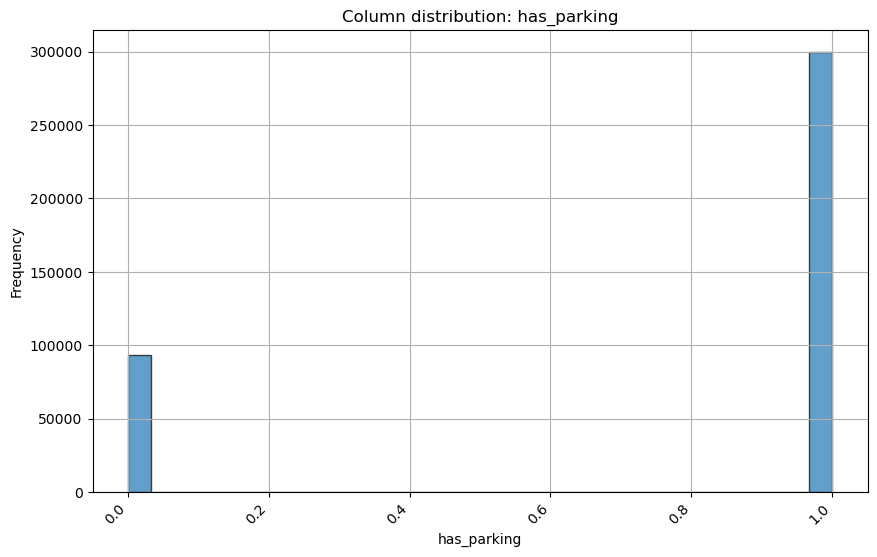

In [87]:
analyze_column(train_df, "has_parking")

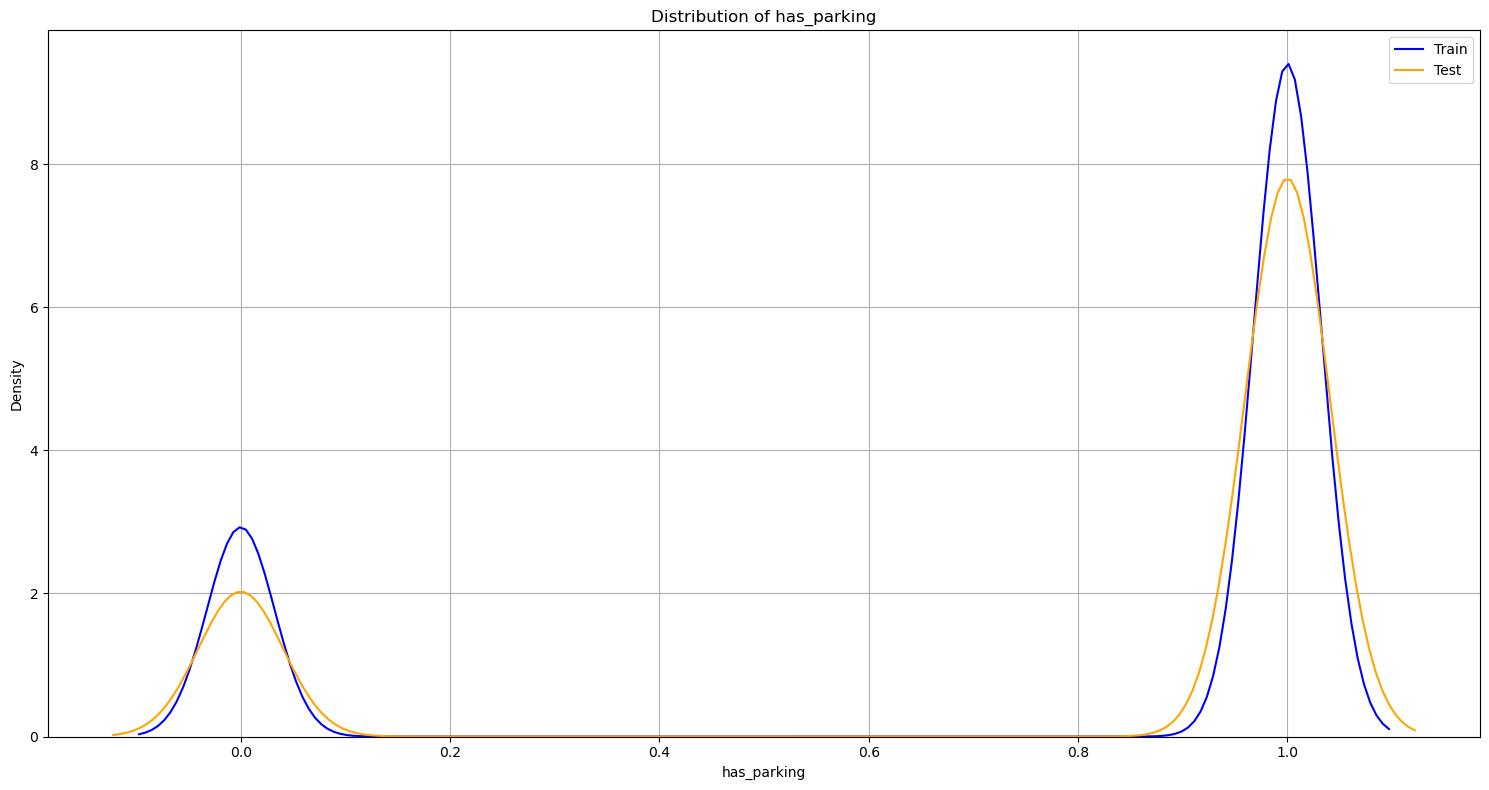

In [88]:
plt.figure(figsize=(15, 8))
sns.kdeplot(train_df["has_parking"], label="Train", color="blue")
sns.kdeplot(test_df["has_parking"], label="Test", color="orange")
plt.title("Distribution of has_parking")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

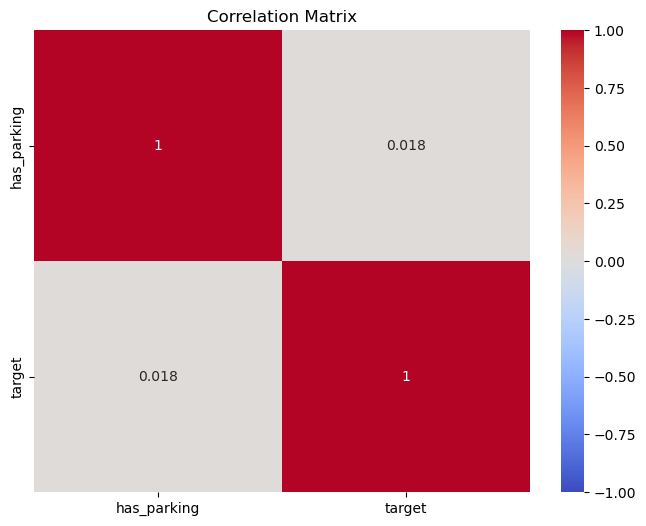

In [89]:
corr_matrix = train_df[["has_parking", "target"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Everything seems normal with the values of this feature. 

### Rooms

rooms_en

Descriptive statistics:
count     354036
unique        13
top        1 B/R
freq      132158
Name: rooms_en, dtype: object

 Number of missing values: 38835

Unique values and its frequency:
rooms_en
1 B/R          132158
2 B/R           91759
Studio          56223
3 B/R           50576
NaN             38835
4 B/R           20697
5 B/R            2148
PENTHOUSE         254
6 B/R             166
Single Room        34
7 B/R              11
Shop                5
Office              3
9 B/R               2
Name: count, dtype: int64


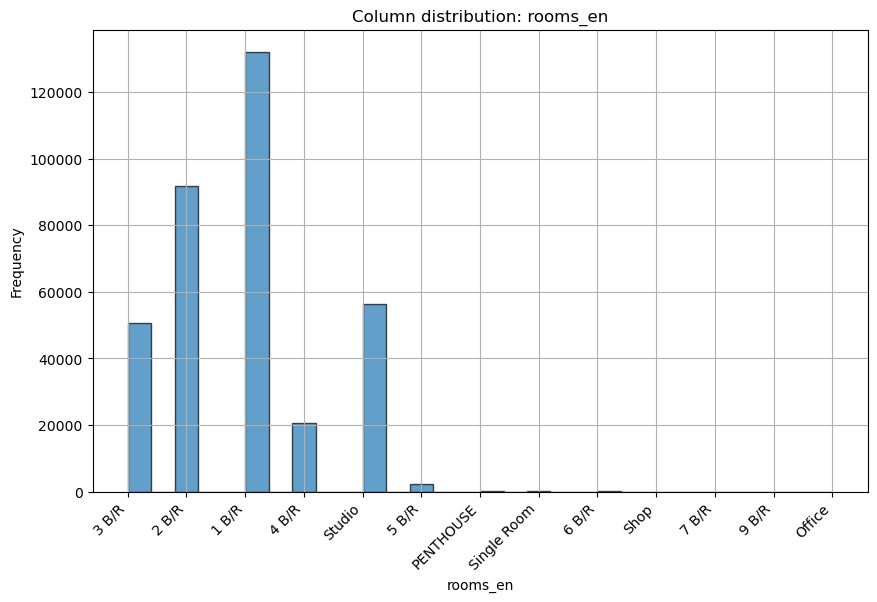

In [92]:
analyze_column(train_df, "rooms_en")

In [93]:
train_df.groupby("rooms_en")["property_type_en"].value_counts()

rooms_en     property_type_en
1 B/R        Unit                131427
             Villa                  731
2 B/R        Unit                 88196
             Villa                 3563
3 B/R        Unit                 27516
             Villa                23060
4 B/R        Villa                17014
             Unit                  3683
5 B/R        Villa                 1743
             Unit                   405
6 B/R        Villa                  116
             Unit                    50
7 B/R        Villa                    8
             Unit                     3
9 B/R        Unit                     2
Office       Unit                     3
PENTHOUSE    Unit                   254
Shop         Unit                     5
Single Room  Unit                    34
Studio       Unit                 56223
Name: count, dtype: int64

In [94]:
train_df[train_df["rooms_en"].isna()]["property_type_en"].value_counts()

property_type_en
Villa       20380
Land        17020
Building     1099
Unit          336
Name: count, dtype: int64

In [95]:
train_df[train_df["rooms_en"].isna()]["target"].sort_values()

773429           0.64
708843           0.93
756113           1.63
962185           5.00
722207           6.48
             ...     
754595     3801069.84
807757     3801069.84
919950     3801069.84
711089    34995777.30
717256    34995777.30
Name: target, Length: 38835, dtype: float64

The abbreviation B/R could probably stand for the number of bedrooms - then the final number of rooms in these properties could be higher by 1. At the same time there are also Studios (can be both 0 and one bedroom) and Single Room - apparently 0 bedrooms. However, in this case the situation with missing values is not clear at all - if we look at other features of missing values, we can see that the data is missing most often for villas. At the same time villas are most often found in apartments with 4-7 bedrooms. Probably the best solution is to mark missing values as “Unknown values” and leave them as they are for now.

In [97]:
train_df["rooms_en"] = train_df["rooms_en"].fillna("Unknown")
test_df["rooms_en"] = test_df["rooms_en"].fillna("Unknown")

There are also values for “Office” and “Shop” - these are clearly not residential properties, so these rows can be deleted. 

In [99]:
train_df = train_df[~train_df["rooms_en"].isin(["Shop", "Office"])]
test_df = test_df[~test_df["rooms_en"].isin(["Shop", "Office"])]

### procedure_area

In [101]:
train_df["procedure_area"].sort_values()

962819            0.01
1030717           0.29
759519            0.30
759676            0.31
760300            0.35
              ...     
708843       805765.00
773429      1169041.00
763035      4478819.18
1002180    20000812.45
962185     20000812.45
Name: procedure_area, Length: 392863, dtype: float64

There are some incredibly large (over 20 million square meters) and very small (less than 1 square meter) objects. As it was said earlier, it probably means either misrepresentation or acquisition of a share of housing (or on the contrary a land plot for building a residential area). 

In [103]:
train_df[train_df["procedure_area"] < 5]

,trans_group_id,trans_group_en,procedure_name_en,date,property_type_id,property_type_en,property_sub_type_id,property_sub_type_en,reg_type_en,area_name_en,...,has_parking,procedure_area,actual_worth,target,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,year
710459,3,Gifts,Grant,2022-01-09,4,Villa,4.0,Villa,Existing Properties,Al Thanayah Fourth,...,0,3.28,22693.0,6918.62,NaN,NaN,1.0,1.0,0.0,2022
725321,1,Sales,Sell - Pre registration,2022-03-18,4,Villa,4.0,Villa,Off-Plan Properties,Jumeirah First,...,0,4.13,60270.0,14593.22,NaN,NaN,1.0,1.0,0.0,2022
734549,1,Sales,Sell,2022-04-26,4,Villa,NaN,NaN,Existing Properties,Al Thanyah Fifth,...,0,2.24,87360.0,39000.00,NaN,NaN,1.0,1.0,0.0,2022
750255,1,Sales,Sell - Pre registration,2022-06-23,3,Unit,60.0,Flat,Off-Plan Properties,Wadi Al Safa 3,...,1,2.26,1525000.0,674778.76,NaN,NaN,1.0,1.0,0.0,2022
758674,1,Sales,Sell,2022-07-19,3,Unit,60.0,Flat,Existing Properties,Al Hebiah Fourth,...,1,1.02,14000.0,13725.49,NaN,NaN,1.0,1.0,0.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063614,1,Sales,Sell - Pre registration,2024-08-05,3,Unit,60.0,Flat,Off-Plan Properties,Um Suqaim Third,...,1,0.74,20000.0,27027.03,NaN,NaN,1.0,1.0,0.0,2024
1066946,1,Sales,Sell,2024-08-11,3,Unit,60.0,Flat,Existing Properties,Al Wasl,...,1,2.17,46260.0,21317.97,NaN,NaN,1.0,1.0,0.0,2024
1075952,1,Sales,Sell - Pre registration,2024-08-28,4,Villa,4.0,Villa,Off-Plan Properties,Wadi Al Safa 5,...,0,2.80,40000.0,14285.71,NaN,NaN,1.0,1.0,0.0,2024
1094713,1,Sales,Sell,2024-09-27,3,Unit,60.0,Flat,Existing Properties,Business Bay,...,1,3.02,40800.0,13509.93,NaN,NaN,1.0,1.0,0.0,2024


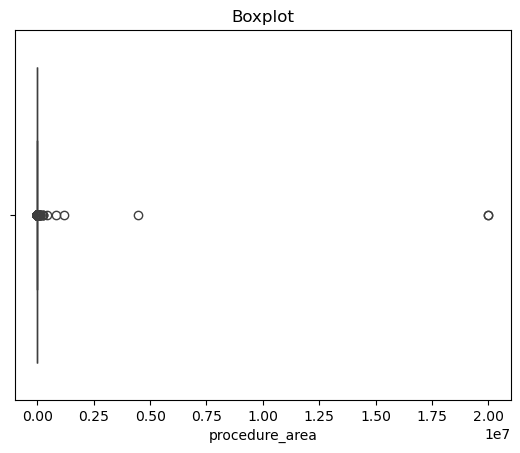

In [104]:
sns.boxplot(data=train_df, x="procedure_area")
plt.title("Boxplot")
plt.savefig("fig4.png")
plt.show()

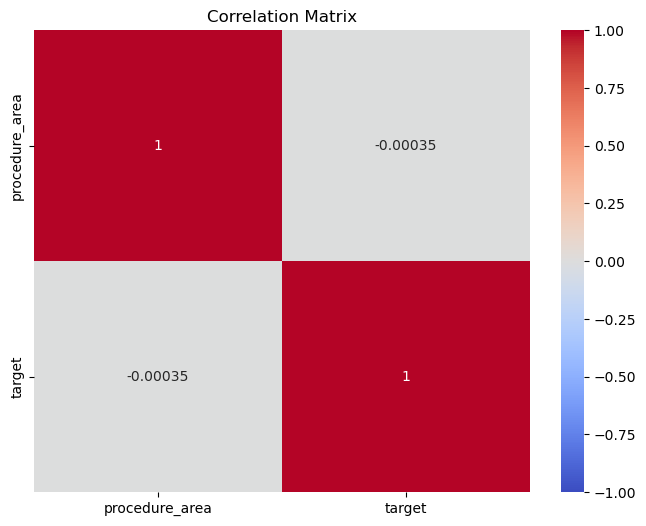

In [105]:
corr_matrix = train_df[["procedure_area", "target"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [106]:
train_df["procedure_area"].sort_values(ascending=False).head(10)

962185     20000812.45
1002180    20000812.45
763035      4478819.18
773429      1169041.00
708843       805765.00
1057728      406647.86
756113       265265.05
756186       265265.05
1073550      254086.90
861357       191780.22
Name: procedure_area, dtype: float64

In [107]:
train_df[train_df["procedure_area"] > 20000000]

,trans_group_id,trans_group_en,procedure_name_en,date,property_type_id,property_type_en,property_sub_type_id,property_sub_type_en,reg_type_en,area_name_en,...,has_parking,procedure_area,actual_worth,target,rent_value,meter_rent_price,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,year
962185,1,Sales,Development Registration,2024-01-24,1,Land,NaN,NaN,Existing Properties,Saih Aldahal,...,0,20000812.45,1.000000e+08,5.00,NaN,NaN,0.0,0.0,2.0,2024
1002180,2,Mortgages,Development Mortgage,2024-04-16,1,Land,NaN,NaN,Existing Properties,Saih Aldahal,...,0,20000812.45,4.248836e+09,212.43,NaN,NaN,0.0,1.0,1.0,2024


Since Dubai law prohibits a person from having less than 5 square meters for living, these objects can definitely be removed at this stage. Too large objects can be left until the stage of creating machine learning models and then decide what to do with them. 

In [109]:
train_df = train_df[train_df["procedure_area"] >= 5]
test_df = test_df[test_df["procedure_area"] >= 5]

### no_of_parties

no_of_parties_role_1

Descriptive statistics:
count    392766.000000
mean          1.147958
std           1.612153
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         415.000000
Name: no_of_parties_role_1, dtype: float64

 Number of missing values: 0

Unique values and its frequency:
no_of_parties_role_1
1.0     355448
2.0      32805
3.0       1492
4.0        976
5.0        638
         ...  
58.0         1
68.0         1
46.0         1
44.0         1
77.0         1
Name: count, Length: 65, dtype: int64


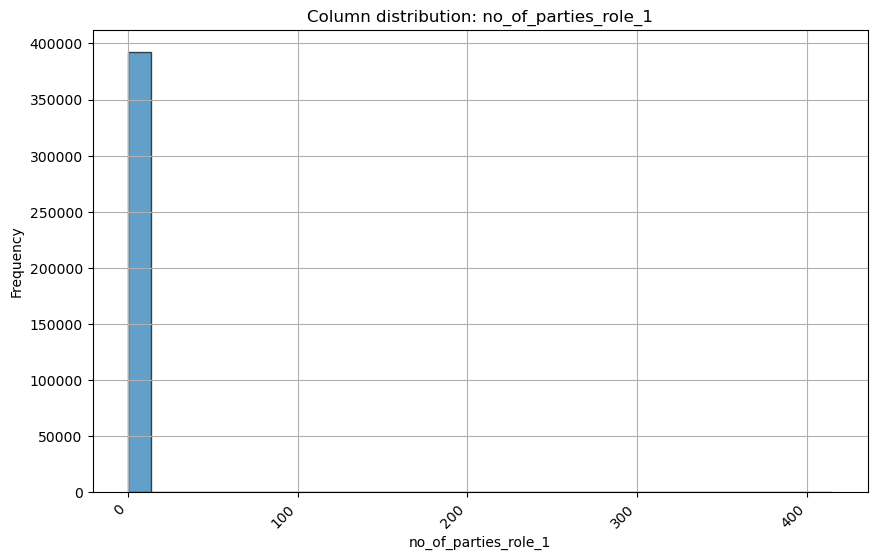

In [111]:
analyze_column(train_df, "no_of_parties_role_1")

no_of_parties_role_2

Descriptive statistics:
count    392766.000000
mean          1.152175
std           0.423501
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          17.000000
Name: no_of_parties_role_2, dtype: float64

 Number of missing values: 0

Unique values and its frequency:
no_of_parties_role_2
1.0     335050
2.0      53107
3.0       2234
0.0       1420
4.0        631
5.0        140
6.0         98
7.0         32
8.0         19
9.0         12
10.0        11
12.0         3
11.0         3
16.0         2
17.0         2
15.0         1
13.0         1
Name: count, dtype: int64


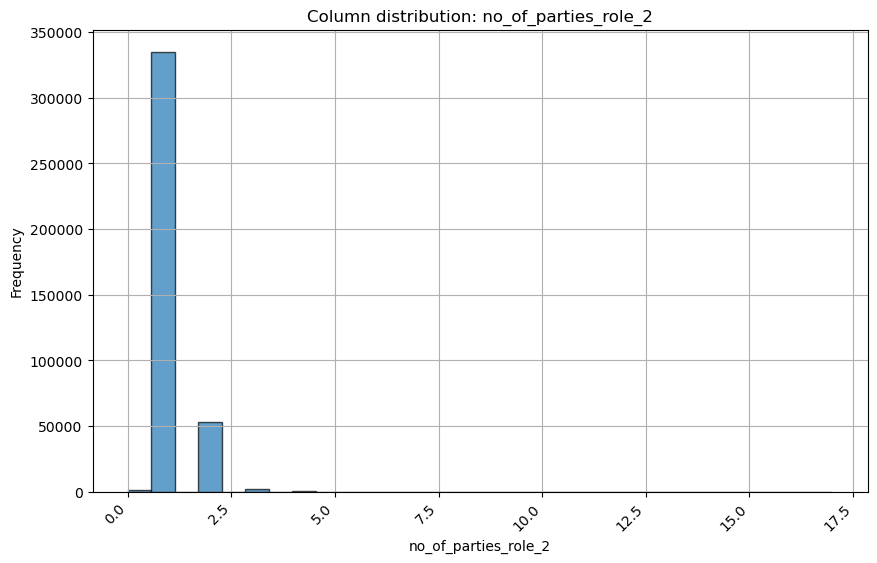

In [112]:
analyze_column(train_df, "no_of_parties_role_2")

no_of_parties_role_3

Descriptive statistics:
count    392766.000000
mean          0.025761
std           0.248865
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: no_of_parties_role_3, dtype: float64

 Number of missing values: 0

Unique values and its frequency:
no_of_parties_role_3
0.0    387747
2.0      2974
1.0      1338
4.0       705
6.0         2
Name: count, dtype: int64


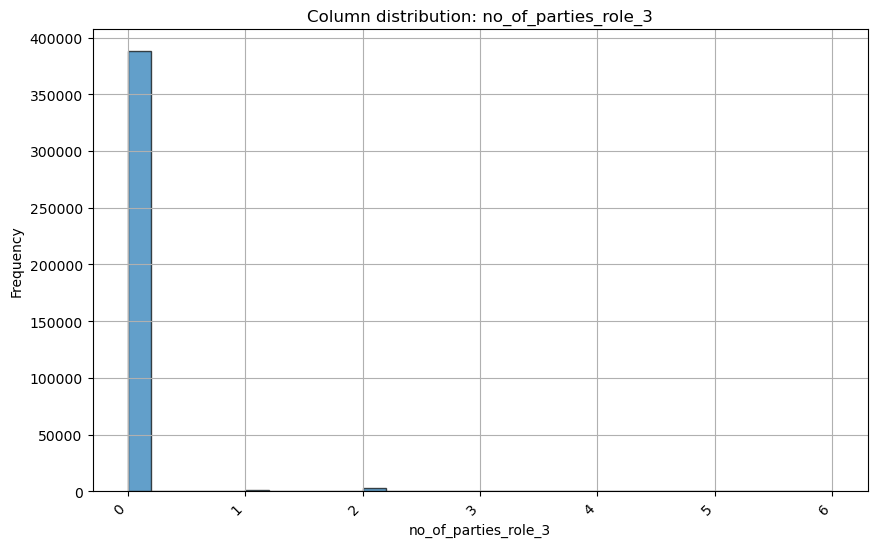

In [113]:
analyze_column(train_df, "no_of_parties_role_3")

These features include the number of parties involved in the transaction, but the values seem odd. It is unlikely that the average buyer is aware of the 400+ parties involved in a home purchase transaction. Since the interpretability of the features is one of the key indicators of the success of this study, it would be appropriate to exclude the features for now, but possibly revisit them in the future to see what effect they have on the target variable. 

### rent value & meter_price

rent_value

Descriptive statistics:
count    1.899000e+03
mean     1.846844e+06
std      1.899567e+06
min      1.109650e+05
25%      7.895200e+05
50%      1.365000e+06
75%      2.313525e+06
max      2.500000e+07
Name: rent_value, dtype: float64

 Number of missing values: 390867

Unique values and its frequency:
rent_value
NaN          390867
1000000.0        26
2000000.0        23
1600000.0        12
600000.0         12
              ...  
1306875.0         1
769250.0          1
2975000.0         1
1051520.0         1
894465.0          1
Name: count, Length: 1102, dtype: int64


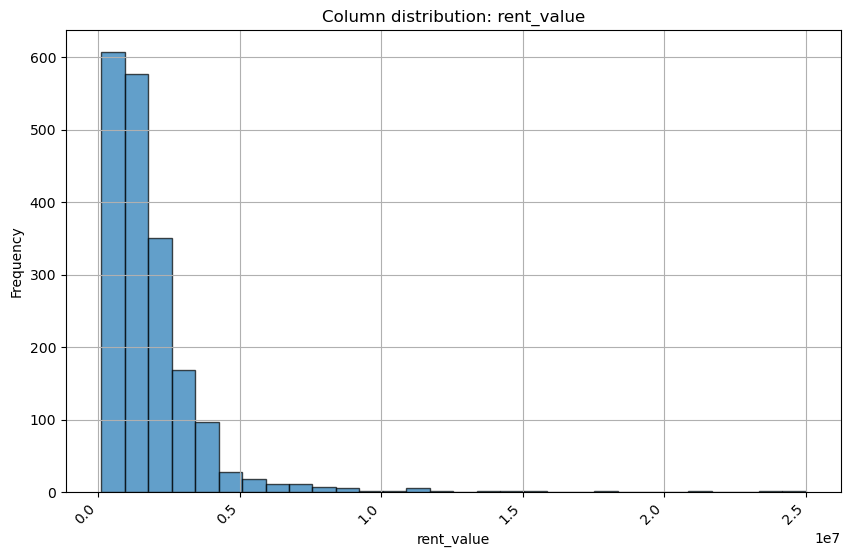

In [116]:
analyze_column(train_df, "rent_value")

meter_rent_price

Descriptive statistics:
count     1899.000000
mean      9375.651264
std       4659.351445
min        499.080000
25%       6187.065000
50%       8517.890000
75%      11382.400000
max      39356.610000
Name: meter_rent_price, dtype: float64

 Number of missing values: 390867

Unique values and its frequency:
meter_rent_price
NaN         390867
7391.38          5
3968.25          3
10705.35         2
6639.69          2
             ...  
5094.15          1
10115.41         1
7006.37          1
6205.53          1
20956.15         1
Name: count, Length: 1800, dtype: int64


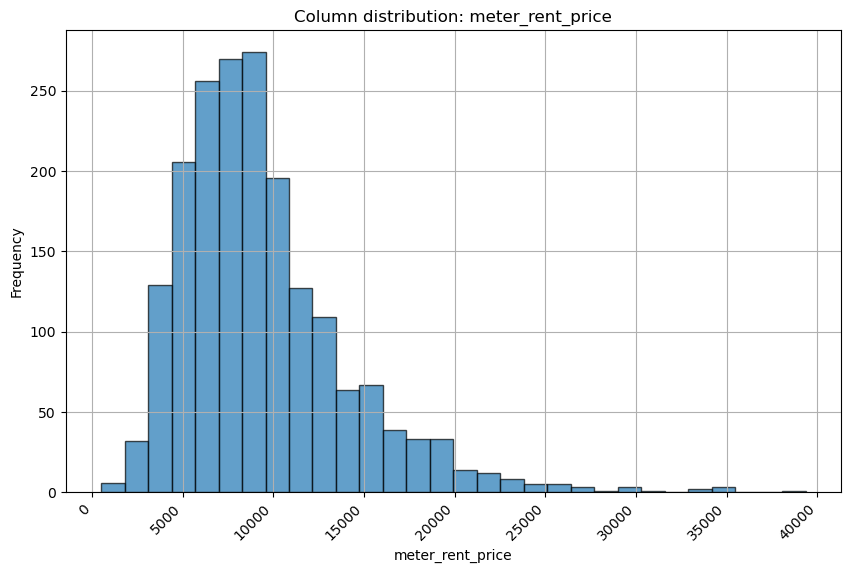

In [117]:
analyze_column(train_df, "meter_rent_price")

In [118]:
mask = train_df[["rent_value", "meter_rent_price"]].notna().any(axis=1)
train_df = train_df[~mask]

mask = test_df[["rent_value", "meter_rent_price"]].notna().any(axis=1)
test_df = test_df[~mask]

In [119]:
train_df = train_df.drop("rent_value", axis=1)
test_df = test_df.drop("rent_value", axis=1)

train_df = train_df.drop("meter_rent_price", axis=1)
test_df = test_df.drop("meter_rent_price", axis=1)

There are a large number of missing values in these features, which apparently mean that the housing was not rented. Since the study is primarily interested in residential properties for purchase, these observations and features can be discarded

### trans_group

trans_group_en

Descriptive statistics:
count     390867
unique         3
top        Sales
freq      312113
Name: trans_group_en, dtype: object

 Number of missing values: 0

Unique values and its frequency:
trans_group_en
Sales        312113
Mortgages     63987
Gifts         14767
Name: count, dtype: int64


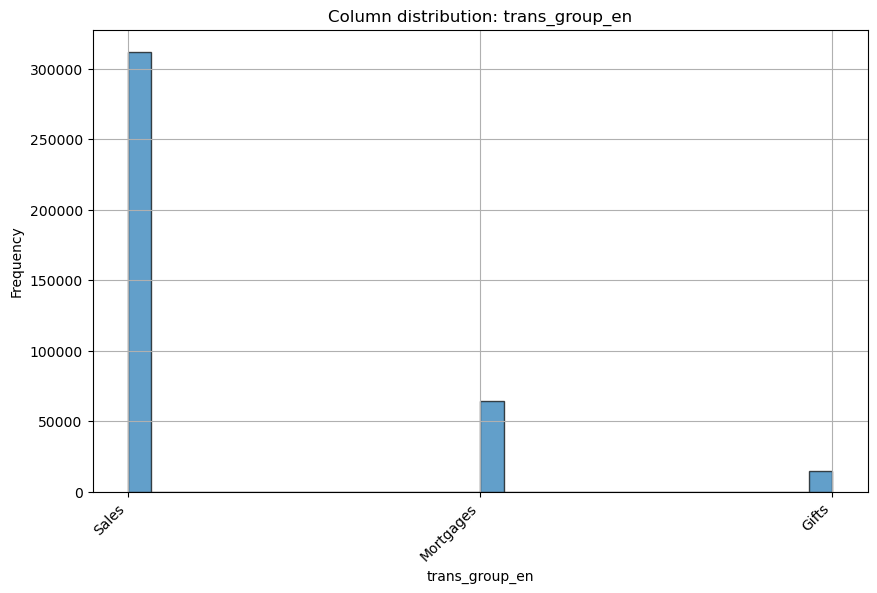

In [122]:
analyze_column(train_df, "trans_group_en")

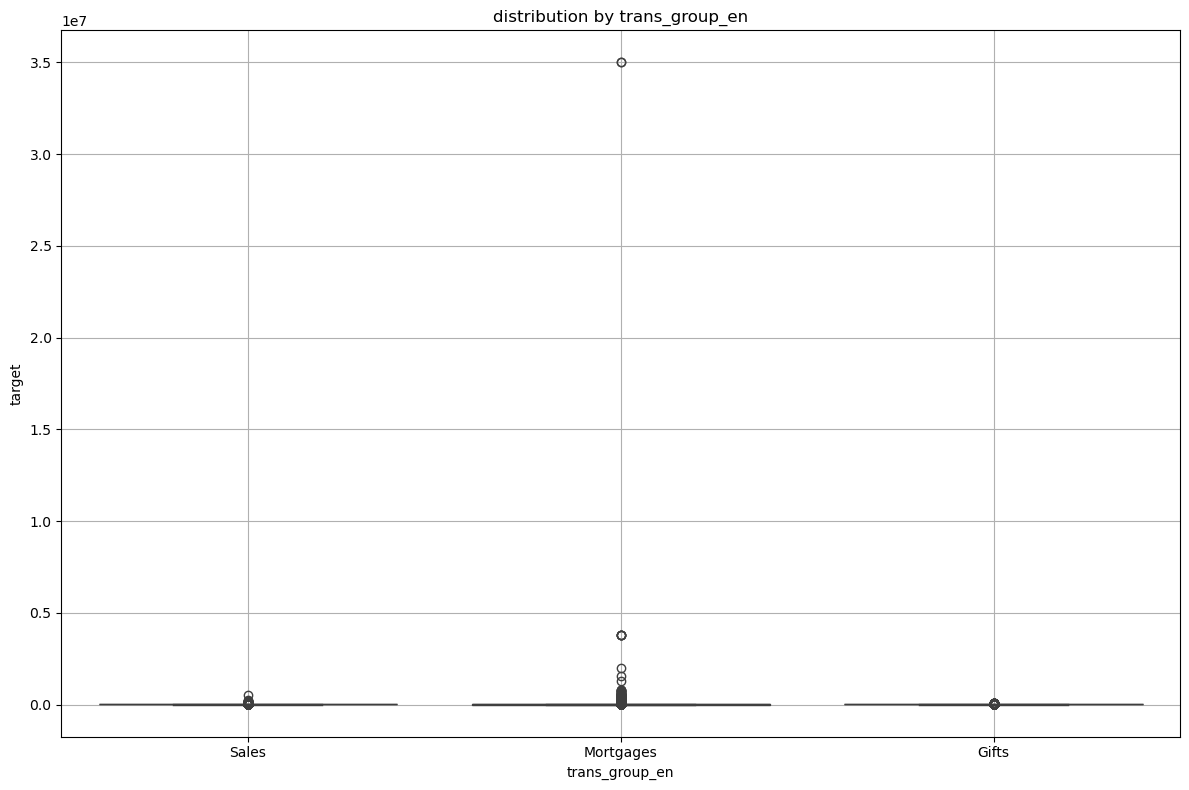

In [123]:
plt.figure(figsize=(12, 8))

sns.boxplot(x=train_df["trans_group_en"], y=train_df["target"], data=train_df)
plt.title("distribution by trans_group_en")
plt.grid(True)
plt.tight_layout()
plt.show()

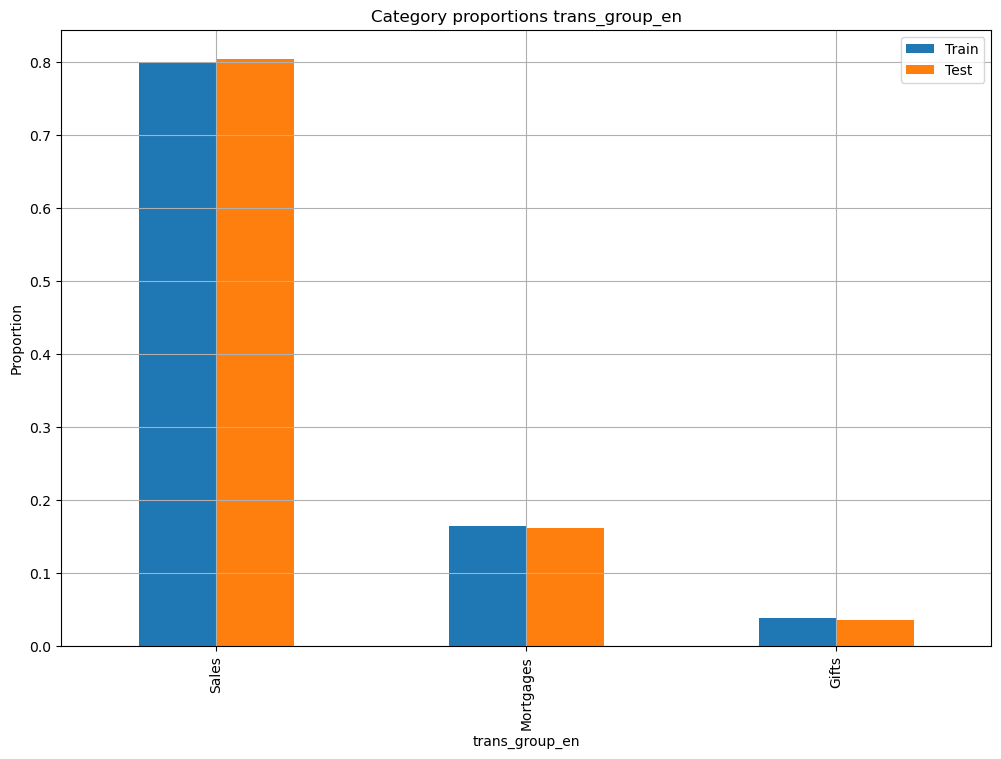

In [124]:
plt.figure(figsize=(12, 8))

train_counts = train_df["trans_group_en"].value_counts(normalize=True)
test_counts = test_df["trans_group_en"].value_counts(normalize=True)
df_plot = pd.DataFrame({"Train": train_counts, "Test": test_counts})
df_plot.plot(kind="bar", ax=plt.gca())
plt.title("Category proportions trans_group_en")
plt.ylabel("Proportion")

plt.legend()
plt.grid(True)

In [125]:
train_df[train_df["trans_group_en"] == "Gifts"].head()

,trans_group_id,trans_group_en,procedure_name_en,date,property_type_id,property_type_en,property_sub_type_id,property_sub_type_en,reg_type_en,area_name_en,...,nearest_mall_en,rooms_en,has_parking,procedure_area,actual_worth,target,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,year
708085,3,Gifts,Grant Pre-Registration,2022-01-02,3,Unit,60.0,Flat,Off-Plan Properties,Hadaeq Sheikh Mohammed Bin Rashid,...,Mall of the Emirates,3 B/R,1,79.54,1167657.0,14680.13,1.0,1.0,0.0,2022
708134,3,Gifts,Grant,2022-01-02,4,Villa,NaN,NaN,Existing Properties,Wadi Al Safa 6,...,NaN,Unknown,0,466.65,2500000.0,5357.33,1.0,1.0,0.0,2022
708216,3,Gifts,Grant,2022-01-02,1,Land,NaN,NaN,Existing Properties,Muhaisanah Third,...,City Centre Mirdif,Unknown,0,1393.55,2250005.0,1614.59,1.0,1.0,0.0,2022
708345,3,Gifts,Grant,2022-01-02,3,Unit,60.0,Flat,Existing Properties,Al Thanyah Fifth,...,Marina Mall,2 B/R,1,154.59,1555799.0,10064.04,1.0,2.0,0.0,2022
708385,3,Gifts,Grant,2022-01-02,4,Villa,4.0,Villa,Existing Properties,Nad Al Shiba First,...,Dubai Mall,4 B/R,0,309.80,4248758.0,13714.52,1.0,1.0,0.0,2022


The values are high level group type of the transaction (Sales , Mortgages , Gifts). Apartments that are listed as gifts are unlikely to interest investors, but they too have a market price listed, so they can be kept

trans_group_id

Descriptive statistics:
count    390867.000000
mean          1.239266
std           0.507522
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: trans_group_id, dtype: float64

 Number of missing values: 0

Unique values and its frequency:
trans_group_id
1    312113
2     63987
3     14767
Name: count, dtype: int64


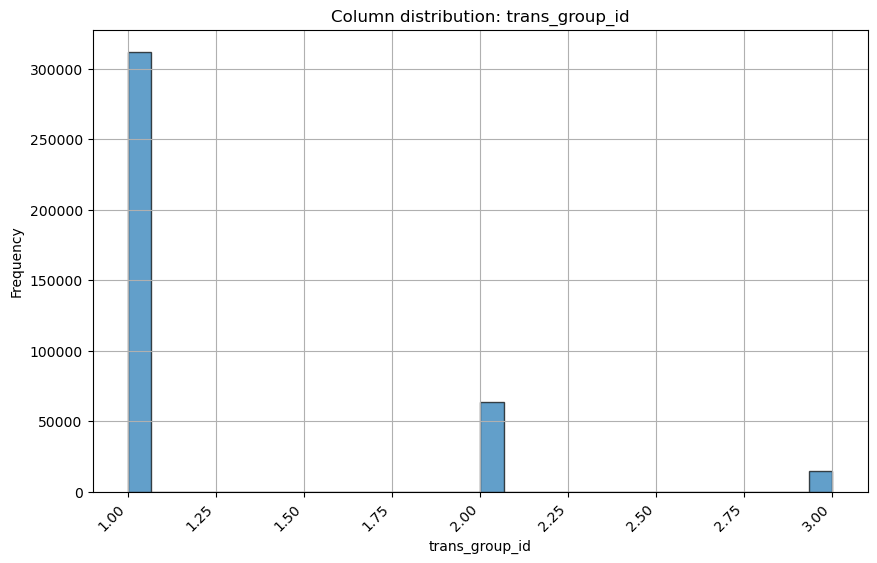

In [127]:
analyze_column(train_df, "trans_group_id")

In [128]:
train_df = train_df.drop("trans_group_id", axis=1)
test_df = test_df.drop("trans_group_id", axis=1)

The id feature values duplicate the values of the main feature, so they can be deleted

### procedure_name

procedure_name_en

Descriptive statistics:
count                      390867
unique                         36
top       Sell - Pre registration
freq                       185733
Name: procedure_name_en, dtype: object

 Number of missing values: 0

Unique values and its frequency:
procedure_name_en
Sell - Pre registration                             185733
Sell                                                 94443
Mortgage Registration                                52706
Delayed Sell                                         24784
Grant                                                12907
Delayed Mortgage                                      5357
Sell Development                                      2813
Modify Mortgage                                       2274
Lease to Own Registration                             1700
Lease Finance Registration                            1509
Development Mortgage                                  1265
Development Registration Pre-Registration          

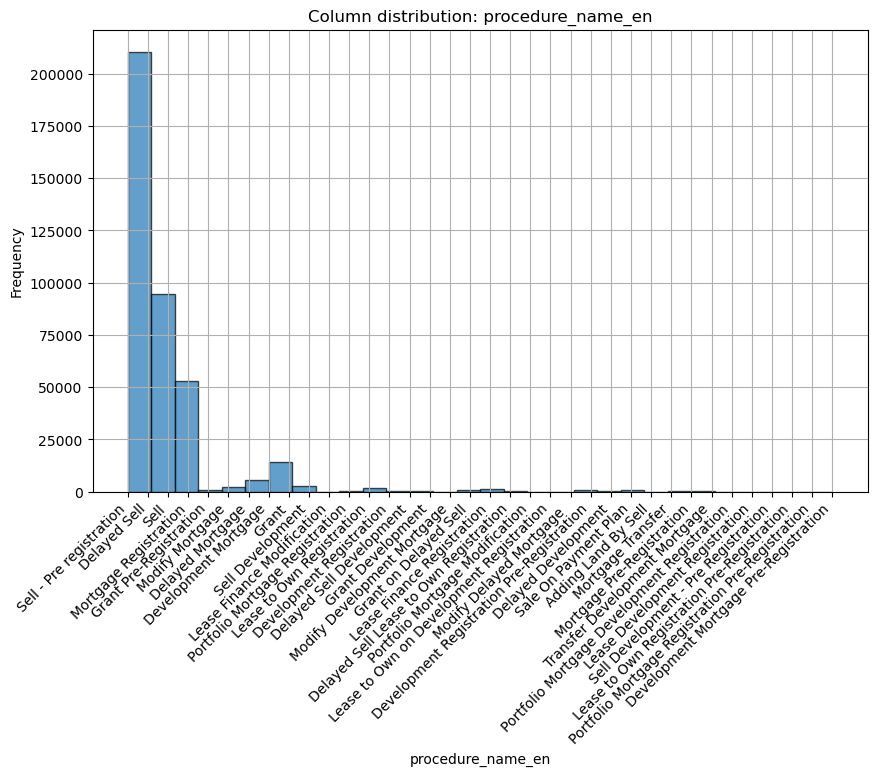

In [131]:
analyze_column(train_df, "procedure_name_en")

It makes sense to first check the performance of the model on the initial values and then apply the aggregation in order to increase the interpretiability of the model

### property_type & sub_type

property_type_en

Descriptive statistics:
count     390867
unique         4
top         Unit
freq      306877
Name: property_type_en, dtype: object

 Number of missing values: 0

Unique values and its frequency:
property_type_en
Unit        306877
Villa        65922
Land         16971
Building      1097
Name: count, dtype: int64


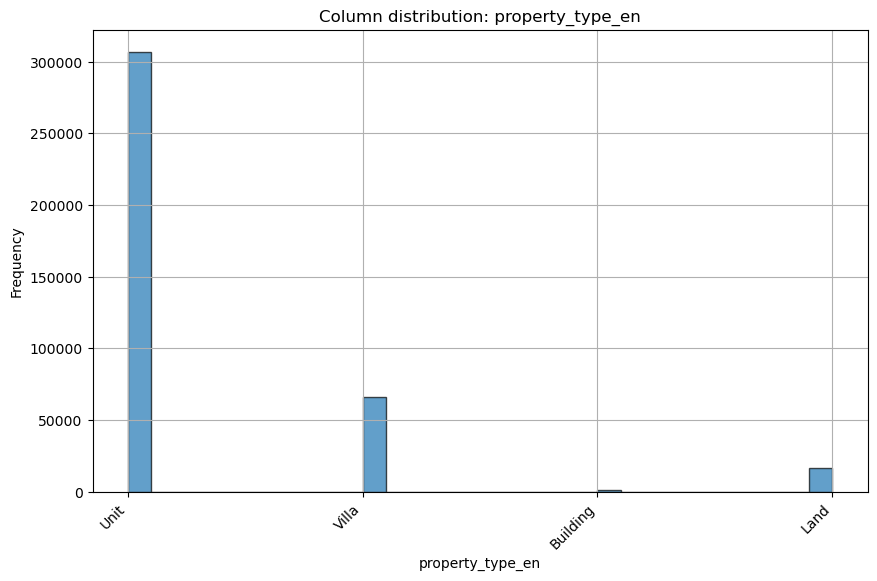

In [134]:
analyze_column(train_df, "property_type_en")

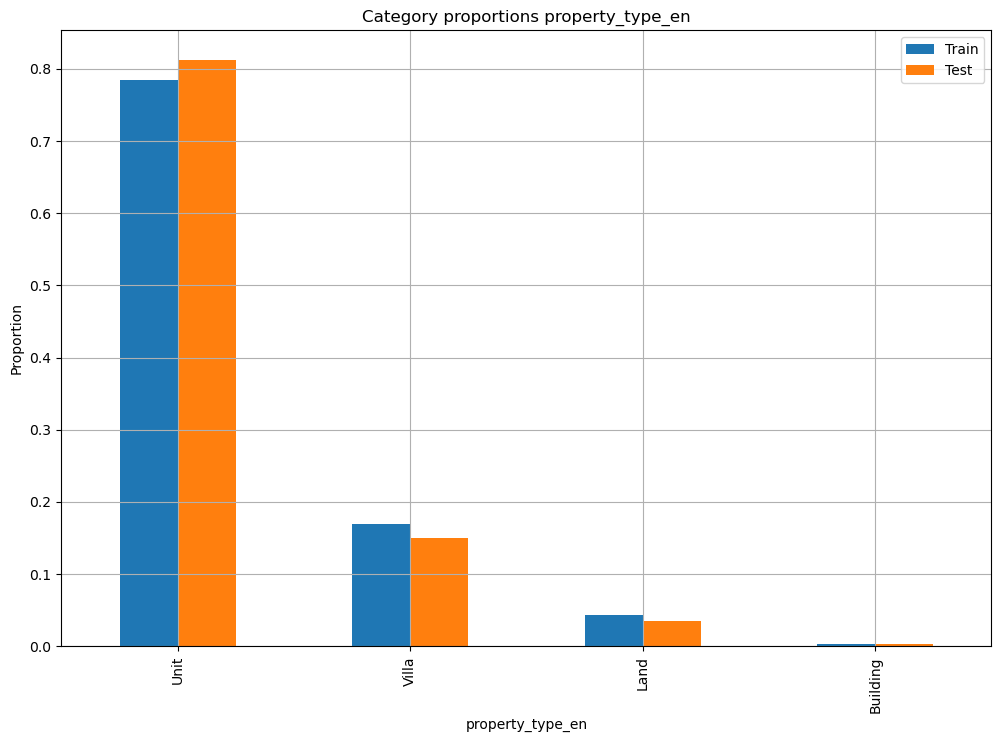

In [135]:
plt.figure(figsize=(12, 8))

train_counts = train_df["property_type_en"].value_counts(normalize=True)
test_counts = test_df["property_type_en"].value_counts(normalize=True)
df_plot = pd.DataFrame({"Train": train_counts, "Test": test_counts})
df_plot.plot(kind="bar", ax=plt.gca())
plt.title("Category proportions property_type_en")
plt.ylabel("Proportion")

plt.legend()
plt.grid(True)
plt.savefig("fig5.png")
plt.show()

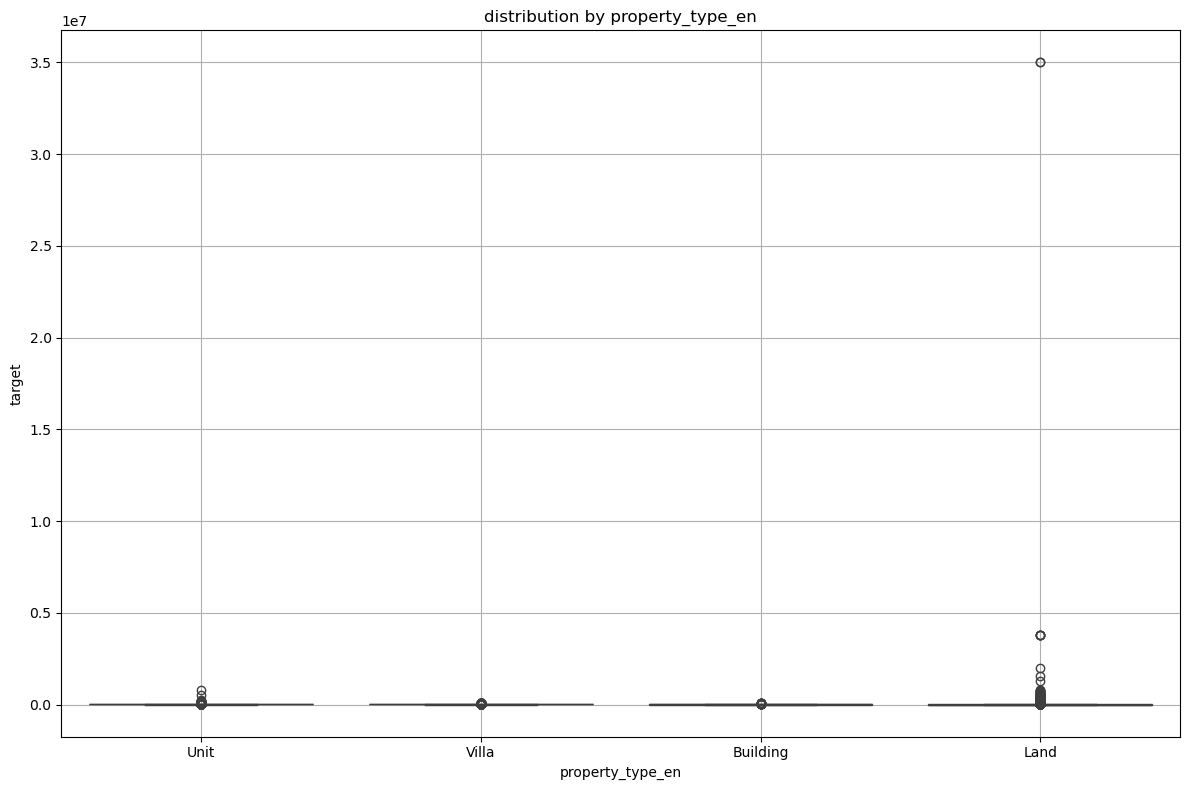

In [136]:
plt.figure(figsize=(12, 8))

sns.boxplot(x=train_df["property_type_en"], y=train_df["target"], data=train_df)
plt.title("distribution by property_type_en")
plt.grid(True)
plt.tight_layout()
plt.show()

property_type_id

Descriptive statistics:
count    390867.000000
mean          3.079012
std           0.582148
min           1.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           4.000000
Name: property_type_id, dtype: float64

 Number of missing values: 0

Unique values and its frequency:
property_type_id
3    306877
4     65922
1     16971
2      1097
Name: count, dtype: int64


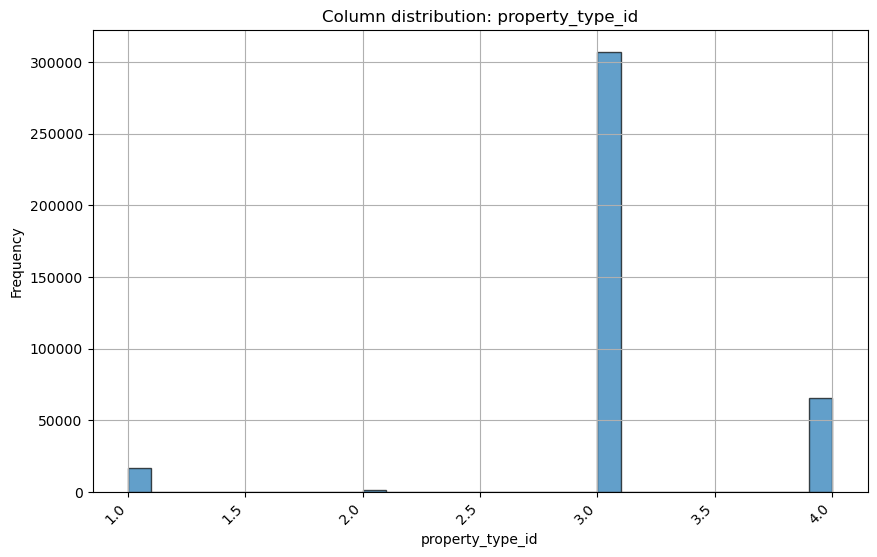

In [137]:
analyze_column(train_df, "property_type_id")

In [138]:
train_df = train_df.drop("property_type_id", axis=1)
test_df = test_df.drop("property_type_id", axis=1)

property_sub_type_en

Descriptive statistics:
count     352740
unique         4
top         Flat
freq      306735
Name: property_sub_type_en, dtype: object

 Number of missing values: 38127

Unique values and its frequency:
property_sub_type_en
Flat                  306735
Villa                  45854
NaN                    38127
Stacked Townhouses       142
Building                   9
Name: count, dtype: int64


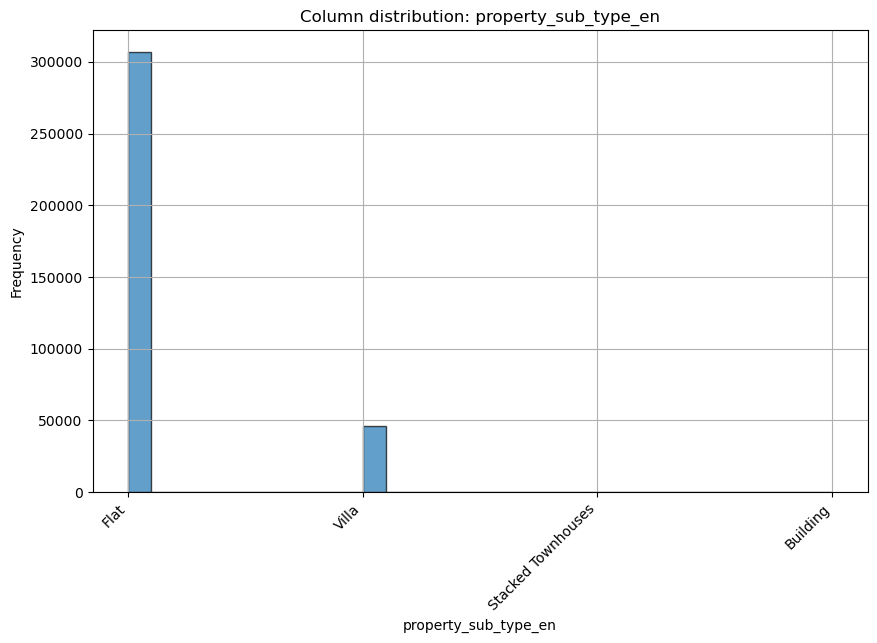

In [139]:
analyze_column(train_df, "property_sub_type_en")

In [140]:
train_df["property_sub_type_en"] = train_df["property_sub_type_en"].fillna("Unknown")
test_df["property_sub_type_en"] = test_df["property_sub_type_en"].fillna("Unknown")

property_sub_type_id

Descriptive statistics:
count    352740.000000
mean         52.724908
std          18.839079
min           2.000000
25%          60.000000
50%          60.000000
75%          60.000000
max          75.000000
Name: property_sub_type_id, dtype: float64

 Number of missing values: 38127

Unique values and its frequency:
property_sub_type_id
60.0    306735
4.0      45854
NaN      38127
75.0       142
2.0          9
Name: count, dtype: int64


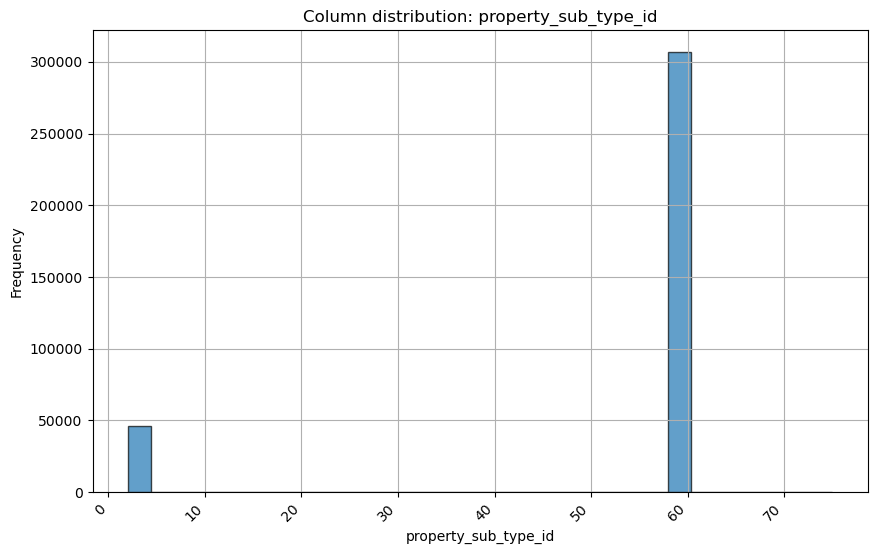

In [141]:
analyze_column(train_df, "property_sub_type_id")

In [142]:
train_df = train_df.drop("property_sub_type_id", axis=1)
test_df = test_df.drop("property_sub_type_id", axis=1)

The reason for missing values is not clear, so it is better to fill them with one value. The column with ID will be processed in the same way as the previous ones

### reg_type

reg_type_en

Descriptive statistics:
count                  390867
unique                      2
top       Existing Properties
freq                   202845
Name: reg_type_en, dtype: object

 Number of missing values: 0

Unique values and its frequency:
reg_type_en
Existing Properties    202845
Off-Plan Properties    188022
Name: count, dtype: int64


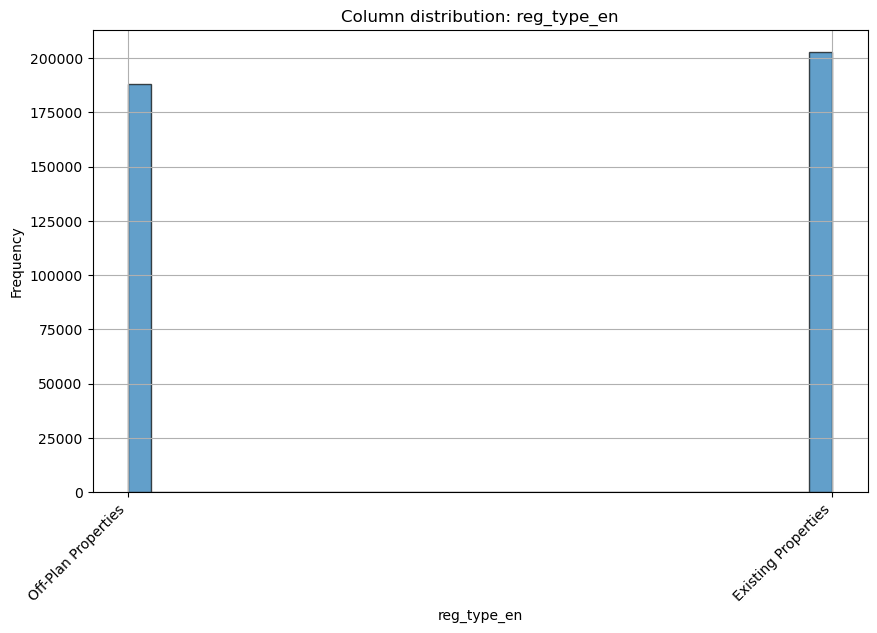

In [145]:
analyze_column(train_df, "reg_type_en")

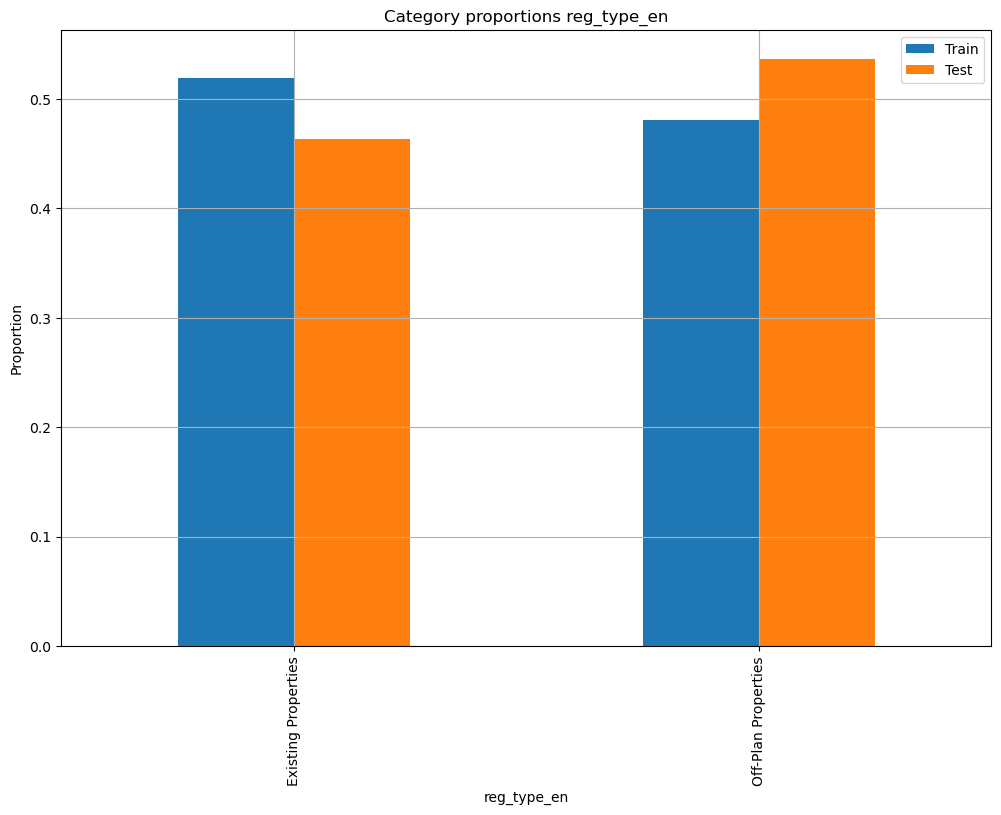

In [146]:
plt.figure(figsize=(12, 8))

train_counts = train_df["reg_type_en"].value_counts(normalize=True)
test_counts = test_df["reg_type_en"].value_counts(normalize=True)
df_plot = pd.DataFrame({"Train": train_counts, "Test": test_counts})
df_plot.plot(kind="bar", ax=plt.gca())
plt.title("Category proportions reg_type_en")
plt.ylabel("Proportion")

plt.legend()
plt.grid(True)

Everything here can be left as it is

### area_name

In [149]:
train_df.area_name_en.nunique()

158

In [150]:
train_df.area_name_en.value_counts()

area_name_en
Al Barsha South Fourth          36640
Marsa Dubai                     27277
Business Bay                    25464
Al Merkadh                      22243
Wadi Al Safa 5                  18006
                                ...  
Ras Al Khor Industrial Third        2
Muhaisanah Second                   1
Al Goze Industrial Second           1
Al Goze Industrial Fourth           1
Saih Shuaib 3                       1
Name: count, Length: 158, dtype: int64

In [151]:
train_df.area_name_en.isna().sum()

0

As for the names of the objects, it is possible to somehow aggregate or combine them with each other. There are no missing values here, and this feature will clearly have an impact on targeting. However, it will be necessary to consider how exactly the user should enter values from this feature to get a prediction for him/herself. 

### building_name & project_name & master_project

In [154]:
train_df.building_name_en.value_counts()

building_name_en
Windsor Residence                    1351
Seven City JLT                       1153
Peninsula Four                       1091
THE EDGE                             1035
Bayz 101 By Danube                   1009
                                     ... 
SUNBEAM HOMES A                         1
Souk Al Warsan Townhouses-C             1
URBANA III STACKED HOUSE BLOCK-11       1
DAMAC LAGOONS - LAGOON VIEWS 13 B       1
MARCO POLO                              1
Name: count, Length: 3309, dtype: int64

In [155]:
train_df.building_name_en.isna().sum()

83990

In [156]:
train_df.project_name_en.value_counts()

project_name_en
SOBHA ONE                      2368
REMRAAM                        1646
Sobha Hartland - The Crest     1611
Address Residences Zabeel      1544
Sobha Creek Vistas Heights     1336
                               ... 
SUNSET GROVE HOMES                1
EMPIRE LAKEVIEWS                  1
Glorious Central Residences       1
A 99                              1
CASSIA PARK                       1
Name: count, Length: 1970, dtype: int64

In [157]:
train_df.project_name_en.isna().sum()

63952

In [158]:
train_df.master_project_en.value_counts()

master_project_en
Jumeirah Village Circle       36268
Business Bay                  25487
Dubai Marina                  14616
The Lagoons                   12891
Burj Khalifa                  11530
                              ...  
AL WARSAN INDUSTRIAL              7
DUBAI HILLS - LAMBOURGHINI        6
Dubai Water Front                 5
Garden View                       2
The Gardens                       1
Name: count, Length: 183, dtype: int64

In [159]:
train_df.master_project_en.isna().sum()

55200

In [160]:
train_df["building_name_en"] = train_df["building_name_en"].fillna("Unknown")
train_df["project_name_en"] = train_df["project_name_en"].fillna("Unknown")
train_df["master_project_en"] = train_df["master_project_en"].fillna("Unknown")

test_df["building_name_en"] = test_df["building_name_en"].fillna("Unknown")
test_df["project_name_en"] = test_df["project_name_en"].fillna("Unknown")
test_df["master_project_en"] = test_df["master_project_en"].fillna("Unknown")

project_number

Descriptive statistics:
count    326915.000000
mean       2104.208911
std         708.467446
min          10.000000
25%        1713.000000
50%        2240.000000
75%        2611.000000
max        3577.000000
Name: project_number, dtype: float64

 Number of missing values: 63952

Unique values and its frequency:
project_number
NaN       63952
2948.0     2368
975.0      1646
2447.0     1611
2957.0     1544
          ...  
3359.0        1
3236.0        1
824.0         1
819.0         1
254.0         1
Name: count, Length: 1973, dtype: int64


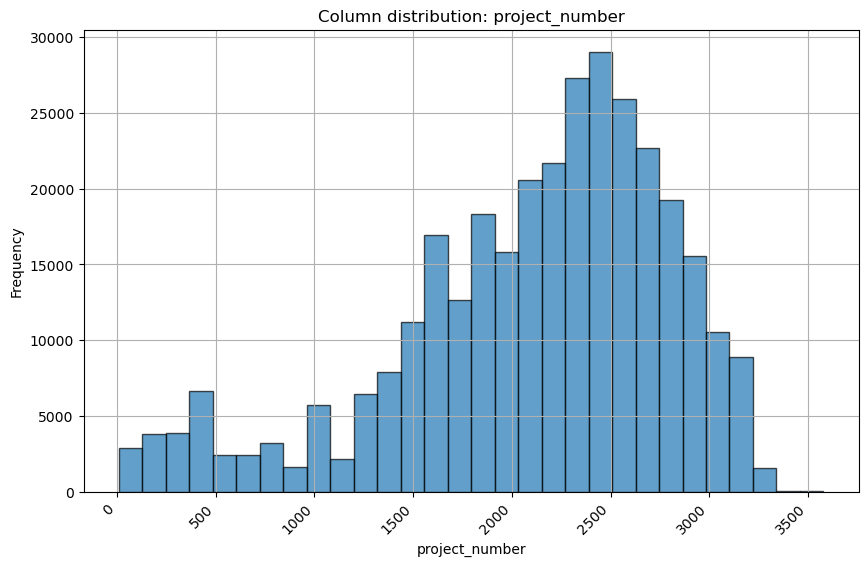

In [161]:
analyze_column(train_df, "project_number")

In [162]:
train_df = train_df.drop("project_number", axis=1)
test_df = test_df.drop("project_number", axis=1)

There are even more unique values here and missing values are observed. The reasons for their occurrence can be very different. To build a baseline, it is possible to fill missing values by analogy with other features and leave these features in the dataset for the time being

### nearest_landmark & metro & mall

nearest_landmark_en

Descriptive statistics:
count                           303501
unique                              14
top       Sports City Swimming Academy
freq                             78189
Name: nearest_landmark_en, dtype: object

 Number of missing values: 87366

Unique values and its frequency:
nearest_landmark_en
NaN                                  87366
Sports City Swimming Academy         78189
Downtown Dubai                       55387
Burj Al Arab                         39413
Motor City                           34287
IMG World Adventures                 27564
Burj Khalifa                         21109
Dubai International Airport          18372
Expo 2020 Site                       10929
Dubai Cycling Course                  7923
Global Village                        3721
Al Makhtoum International Airport     2988
Hamdan Sports Complex                 2258
Dubai Parks and Resorts               1358
Jabel Ali                                3
Name: count, dtype: int64

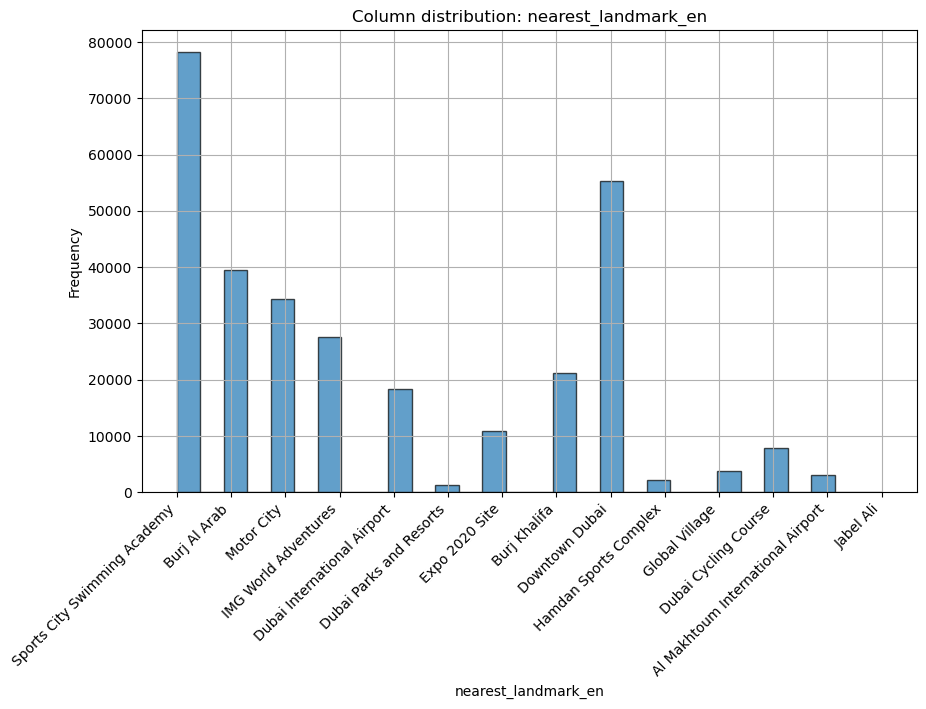

In [165]:
analyze_column(train_df, "nearest_landmark_en")

nearest_metro_en

Descriptive statistics:
count                                   257106
unique                                      54
top       Buj Khalifa Dubai Mall Metro Station
freq                                     36604
Name: nearest_metro_en, dtype: object

 Number of missing values: 133761

Unique values and its frequency:
nearest_metro_en
NaN                                     133761
Buj Khalifa Dubai Mall Metro Station     36604
Dubai Internet City                      29225
Business Bay Metro Station               27802
Nakheel Metro Station                    22511
First Abu Dhabi Bank Metro Station       15548
Sharaf Dg Metro Station                  14026
Damac Properties                         13518
Creek Metro Station                      12407
Rashidiya Metro Station                  10758
Jumeirah Lakes Towers                    10245
Ibn Battuta Metro Station                 8161
Palm Jumeirah                             5738
Harbour Tower                      

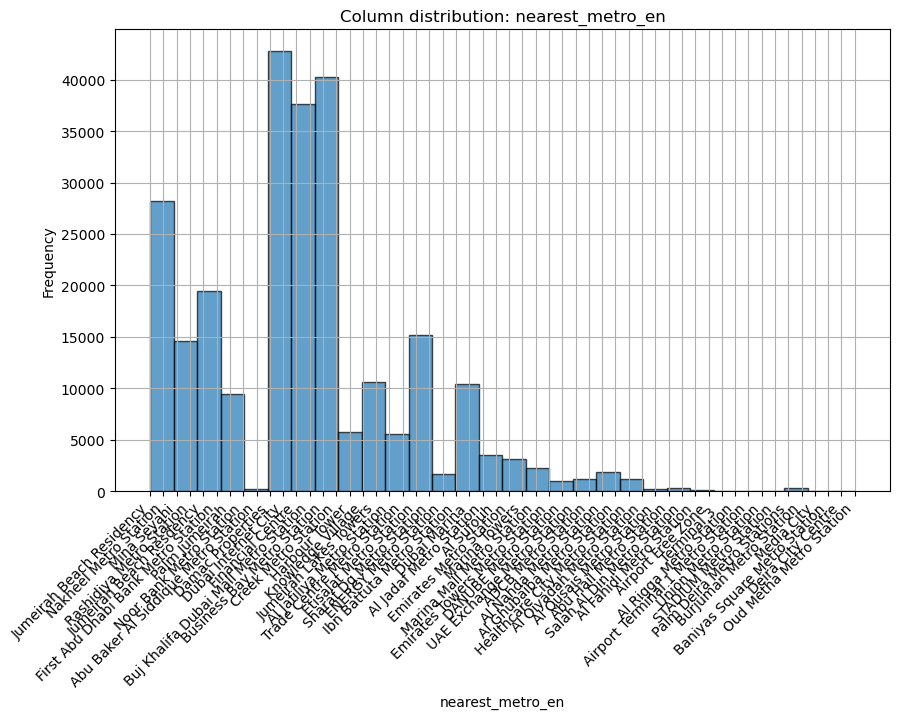

In [166]:
analyze_column(train_df, "nearest_metro_en")

nearest_mall_en

Descriptive statistics:
count          255391
unique              5
top       Marina Mall
freq            81939
Name: nearest_mall_en, dtype: object

 Number of missing values: 135476

Unique values and its frequency:
nearest_mall_en
NaN                     135476
Marina Mall              81939
Dubai Mall               80033
Mall of the Emirates     52854
City Centre Mirdif       23101
Ibn-e-Battuta Mall       17464
Name: count, dtype: int64


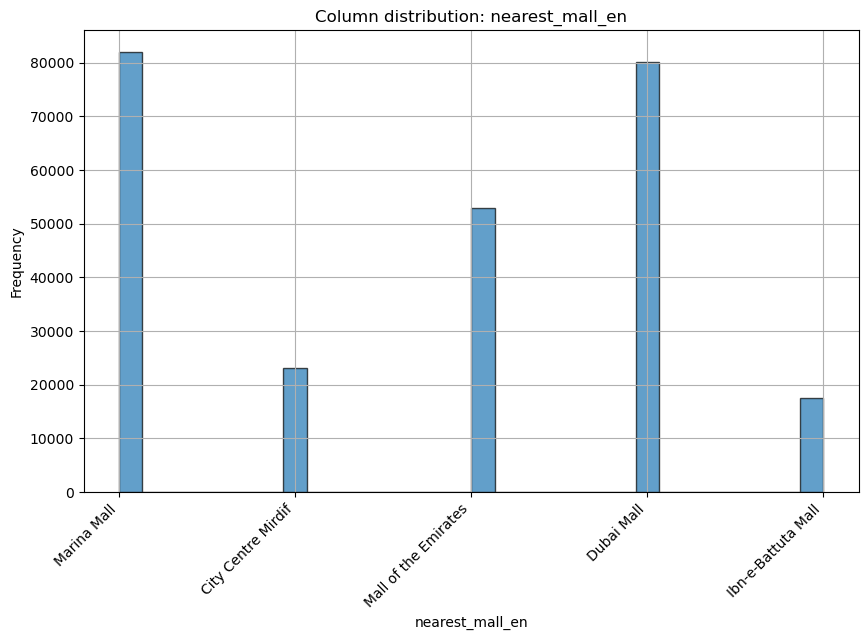

In [167]:
analyze_column(train_df, "nearest_mall_en")

In [168]:
train_df["nearest_landmark_en"] = train_df["nearest_landmark_en"].fillna("Unknown")
train_df["nearest_metro_en"] = train_df["nearest_metro_en"].fillna("Unknown")
train_df["nearest_mall_en"] = train_df["nearest_mall_en"].fillna("Unknown")

test_df["nearest_landmark_en"] = test_df["nearest_landmark_en"].fillna("Unknown")
test_df["nearest_metro_en"] = test_df["nearest_metro_en"].fillna("Unknown")
test_df["nearest_mall_en"] = test_df["nearest_mall_en"].fillna("Unknown")

## Calculate correlation

In [170]:
calculate_correlations(train_df, "target")

Pearson correlation

Most powerful correlations
actual_worth            0.617165
no_of_parties_role_1    0.525139
has_parking             0.032717
year                    0.009952
no_of_parties_role_2    0.004060
procedure_area         -0.000635
no_of_parties_role_3   -0.005078
Name: target, dtype: float64


Obviously, the most correlated feature is price. It is significant that the correlation coefficient is only 0.6, which indicates the presence of outliers and anomalies in the dataset. 

# Modeling

## 1. Baseline

Since most of the features in the dataset are categorical, with many unique values, it makes sense to consider CatBoost-based gradient bousting as the main model, the main advantage of which is working with categorical features. 

In [175]:
numeric_features = ["procedure_area"]
cat_features = [
    "trans_group_en",
    "procedure_name_en",
    "property_type_en",
    "property_sub_type_en",
    "reg_type_en",
    "area_name_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
    "has_parking",
]

It needs to be fed categorical features separately as input. It should also remove those features that were found to be weakly interpretable during EDA (number of parties) and actual worth.

In [177]:
X_train_baseline = train_df.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_train_baseline = train_df["target"]
X_test_baseline = test_df.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_test_baseline = test_df["target"]

Hyperparameter selection will be done using Optuna. Model results will be logged in MLflow and feature importance will be determined using SHAP

In [179]:
trainer = ModelTrainer(
    experiment_name="Dubai_Property_CatBoost", model_base_name="dubai_catboost"
)

MLflow experiment set to: Dubai_Property_CatBoost


The RMSE will be used as the error function. Since there are many outliers and anomalies in the data, it also makes sense to log the MAE. R^2 can also be compared for interpretability of the models. 

In [181]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_baseline,
#     y_train=y_train_baseline,
#     X_test=X_test_baseline,
#     y_test=y_test_baseline,
#     cat_features=cat_features,
#     n_trials=10,
#     cv_splits_for_optuna=5
# )

In [182]:
run_id = "85148da2676e4d66b7702d495cfa325f"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 14656.227771035308,
 'test_r2': -0.0847211085217634,
 'test_rmse': 18532.9915184724,
 'test_mae': 3944.396019193546,
 'train_rmse': 12447.087009998912}

The baseline model has not shown itself to be the best: RMSE on the test amounted to 18532. R^2 turned out to be negative, which is worse than the prediction by the mean. 

## Hypothesises testing

### 2. Keeping "number of parties" features

It will be curious to compare the same dataset, but with features (number of parties) included, to the baseline. They correlated quite well with the target feature, but due to weak interpretability they cannot be used in further analysis. 

In [187]:
train_df["no_of_parties_role_1"] = train_df["no_of_parties_role_1"].astype(int)
train_df["no_of_parties_role_2"] = train_df["no_of_parties_role_2"].astype(int)
train_df["no_of_parties_role_3"] = train_df["no_of_parties_role_3"].astype(int)

test_df["no_of_parties_role_1"] = test_df["no_of_parties_role_1"].astype(int)
test_df["no_of_parties_role_2"] = test_df["no_of_parties_role_2"].astype(int)
test_df["no_of_parties_role_3"] = test_df["no_of_parties_role_3"].astype(int)

In [188]:
X_train_v2 = train_df.drop(["actual_worth", "target"], axis=1)
y_train_v2 = train_df["target"]
X_test_v2 = test_df.drop(["actual_worth", "target"], axis=1)
y_test_v2 = test_df["target"]

In [189]:
numeric_features = ["procedure_area"]
cat_features = [
    "trans_group_en",
    "procedure_name_en",
    "property_type_en",
    "property_sub_type_en",
    "reg_type_en",
    "area_name_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
    "has_parking",
    "no_of_parties_role_3",
]

In [190]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v2,
#     y_train=y_train_v2,
#     X_test=X_test_v2,
#     y_test=y_test_v2,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [191]:
run_id = "ae26b2c5bd3848ce90f09f04668bc762"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 14224.599853833737,
 'test_r2': 0.9012492814028756,
 'test_rmse': 5591.864169367325,
 'test_mae': 3017.9901771708755,
 'train_rmse': 4417.419982637892}

Apparently there are some hidden patterns in these features that CatBoost has found. R^2 increased sharply to 0.9, and RMSE decreased to 5591. Unfortunately, it is not possible to use these features in an applied study, but these are the numbers that can be used as a comparison of the power of the models in the future. 

### 3. Transforming target feature

Since the target feature becomes more normal after logarithmization, we can try to compare the results of the models by applying this transformation to the target. The dataset and features remain exactly the same as in the baseline. 

In [195]:
X_train_v3 = train_df.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_train_v3 = train_df["target"]
X_test_v3 = test_df.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_test_v3 = test_df["target"]

In [196]:
y_train_v3 = np.log1p(y_train_v3)

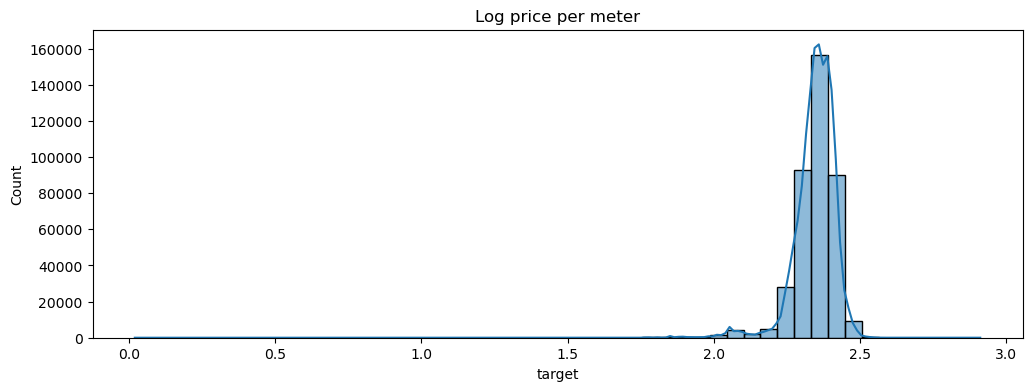

In [197]:
plt.figure(figsize=(12, 4))
sns.histplot(np.log1p(y_train_v3), bins=50, kde=True)
plt.title("Log price per meter")
plt.show()

In [198]:
numeric_features = ["procedure_area"]
cat_features = [
    "trans_group_en",
    "procedure_name_en",
    "property_type_en",
    "property_sub_type_en",
    "reg_type_en",
    "area_name_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
    "has_parking",
]

In [199]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v3,
#     y_train=y_train_v3,
#     X_test=X_test_v3,
#     y_test=y_test_v3,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [200]:
run_id = "d48764e82aba40d598e3e4716175b718"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.2714014446238236,
 'test_r2': -0.05518874976090915,
 'test_rmse': 18278.963149658928,
 'test_mae': 8298.31404262723,
 'train_rmse': 44750.33424997238}

The results were slightly better, with RMSE dropping to 18278, and R^2, although still negative, also increased slightly to -0.05. Overall, the logarithmization of the targeting helped a bit, albeit not enough, so in general you can continue to use this method in the future. 

### 4. Removing anomalies from target

Obviously, transformations of the target feature are necessary. The easiest way to identify anomalies is to recalculate the estimated property price (price per square meter multiplied by area) and compare it to the actual worth specified in the dataset. To avoid determining the cutoff threshold manually, the interquartile range can be used to eliminate the largest and most unrealistic difference

In [204]:
train_calculated_worth = train_df["target"] * train_df["procedure_area"]
train_price_diff = train_calculated_worth - train_df["actual_worth"]

In [205]:
Q1 = train_price_diff.quantile(0.25)
Q3 = train_price_diff.quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

In [206]:
clean_train = train_df[abs(train_price_diff) <= threshold]

In [207]:
test_calculated_worth = test_df["target"] * test_df["procedure_area"]
test_price_diff = test_calculated_worth - test_df["actual_worth"]

clean_test = test_df[abs(test_price_diff) <= threshold]

In [208]:
X_train_v4 = clean_train.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_train_v4 = clean_train["target"]
X_test_v4 = clean_test.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_test_v4 = clean_test["target"]

In [209]:
y_train_v4 = np.log1p(y_train_v4)

In [210]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v4,
#     y_train=y_train_v4,
#     X_test=X_test_v4,
#     y_test=y_test_v4,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [211]:
run_id = "6f5af74a120e44c6892f34364883797d"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.23781529480157074,
 'test_r2': 0.231370891223466,
 'test_rmse': 15808.158301840826,
 'test_mae': 2712.225475543135,
 'train_rmse': 4990.039546019387}

The results immediately improved markedly - R^2 became positive, and other metrics decreased

### 5. Deep anomaly detection pipeline

There are other ways to detect anomalies in the target feature. One method is to remove 1% of the most extreme values from the univariate boundaries of the three key features. After analyzing housing prices in Dubai, the boundaries shown below can be used as a basis.

In [215]:
column_rules = [
    {"col": "target", "min_val": 500, "max_quant": 0.995},
    {"col": "procedure_area", "min_val": 20, "max_quant": 0.995},
    {"col": "actual_worth", "min_val": 50000, "max_quant": 0.995},
]
train_df_c1, test_df_c1 = remove_univariate_outliers(train_df, test_df, column_rules)

TRAIN 'target': removed 3241 observations
TEST 'target': removed 872 observations
TRAIN 'procedure_area': removed 2424 observations
TEST 'procedure_area': removed 523 observations
TRAIN 'actual_worth': removed 2124 observations
TEST 'actual_worth': removed 553 observations


Next, applying the logic of the third hypothesis, the outliers in the price differences can be removed on both sides. One option is to choose 3 rather than 1.5 as the coefficient for the interquartile range, which would result in fewer observations being removed.

In [217]:
train_df_c2, test_df_c2 = remove_price_discrepancy_outliers(
    train_df_c1, test_df_c1, "target", "procedure_area", "actual_worth"
)

TRAIN 'price_diff': removed 18150 observations
TEST 'price_diff': removed 3074 observations


In [218]:
numeric_cols_for_iso = ["procedure_area"]

In [219]:
X_train_processed = train_df_c2.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_train_log = train_df_c2["target"]
X_test_processed = test_df_c2.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_test_original = test_df_c2["target"]

It is also possible to apply Isolation Forest machine learning algorithm for anomaly detection. Contamination is used as a hyperparameter, i.e., it is the percentage of observations that the model will recognize as outliers and remove them. 

In [221]:
X_train_v5, X_test_v5, y_train_v5, y_test_v5 = remove_feature_outliers_isoforest(
    X_train_processed,
    X_test_processed,
    y_train_log,
    y_test_original,
    numeric_cols_for_iso,
    contamination=0.02,
)

TRAIN (Isolation Forest): removed 7404 observations
TEST (Isolation Forest): removed 1288 observations


In [222]:
y_train_v5 = np.log1p(y_train_v5)

In [223]:
if "train_df" in locals() and "X_train_v5" in locals():
    kept_train_indices = X_train_v5.index
    removed_train_indices = train_df.index.difference(kept_train_indices)
    removed_train_df = train_df.loc[removed_train_indices]

if "test_df" in locals() and "X_test_v5" in locals():
    kept_test_indices = X_test_v5.index
    removed_test_indices = test_df.index.difference(kept_test_indices)
    removed_test_df = test_df.loc[removed_test_indices]

So train is reduced by 7% ( test is less than 6%), and the deleted values can be collected in a separate dataset to look at the distributions. 

In [225]:
len(removed_train_df)

27678

In [226]:
removed_train_df.describe()

,date,has_parking,procedure_area,actual_worth,target,no_of_parties_role_1,no_of_parties_role_2,no_of_parties_role_3,year
count,27678,27678.000000,2.767800e+04,2.767800e+04,2.767800e+04,27678.000000,27678.000000,27678.000000,27678.000000
mean,2023-06-09 23:48:58.218079232,0.060228,2.891803e+03,1.373414e+07,1.291648e+04,1.494400,1.125443,0.026230,2022.948804
min,2022-01-02 00:00:00,0.000000,5.260000e+00,1.000000e+00,2.000000e-02,0.000000,0.000000,0.000000,2022.000000
25%,2022-10-11 00:00:00,0.000000,6.857050e+02,1.504944e+06,1.430182e+03,1.000000,1.000000,0.000000,2022.000000
50%,2023-06-26 00:00:00,0.000000,9.104500e+02,4.127656e+06,5.278140e+03,1.000000,1.000000,0.000000,2023.000000
75%,2024-01-29 00:00:00,0.000000,1.183725e+03,9.000000e+06,9.994995e+03,1.000000,1.000000,0.000000,2024.000000
max,2024-10-09 00:00:00,1.000000,2.000081e+07,1.378694e+10,3.499578e+07,415.000000,15.000000,4.000000,2024.000000
std,NaN,0.237914,1.723901e+05,2.372470e+08,3.030174e+05,5.127421,0.488642,0.225946,0.776001


In [227]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v5,
#     y_train=y_train_v5,
#     X_test=X_test_v5,
#     y_test=y_test_v5,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [228]:
run_id = "6f671f39f02643ba9a10e07eebae7542"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.2167747685809501,
 'test_r2': 0.8219121793318904,
 'test_rmse': 3277.891785770282,
 'test_mae': 2147.652494128196,
 'train_rmse': 2266.3800864908735}

Due to the remote observations, the obtained metrics were greatly improved - R^2 increased to 0.82, which is still inferior to the second hypothesis, but there are no uninterpretable features in the dataset

### 6. Transforming 'procedure_area' feature

Next, the values of the feature responsible for housing area can be logarithmized.

In [232]:
X_train_v6, X_test_v6, y_train_v6, y_test_v6 = remove_feature_outliers_isoforest(
    X_train_processed,
    X_test_processed,
    y_train_log,
    y_test_original,
    numeric_cols_for_iso,
    contamination=0.02,
)

TRAIN (Isolation Forest): removed 7404 observations
TEST (Isolation Forest): removed 1288 observations


In [233]:
X_train_v6["procedure_area"] = np.log1p(X_train_v6["procedure_area"])

In [234]:
y_train_v6 = np.log1p(y_train_v6)

In [235]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v6,
#     y_train=y_train_v6,
#     X_test=X_test_v6,
#     y_test=y_test_v6,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [236]:
run_id = "53f99f41cf57404290f75d4047b452fa"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.22205514087096367,
 'test_r2': -0.2118178410049094,
 'test_rmse': 9597.017121765544,
 'test_mae': 7935.5925999093115,
 'train_rmse': 2790.3190698971243}

The model has clearly been heavily overtrained and the metrics have seriously sagged. It is better to abandon this change. 

### 7. Creating data features

It is possible to extract additional features from the date. The following features will be created: year, month, day, quarter, day of the week, week of the year, day of the year, whether the day is a weekend day, and whether the day marks the beginning or end of the month, quarter, or year. Additionally, highlight seasonality by month. If a feature impacts the model, it will be visible in the SHAP chart.

In [240]:
train_df_v7 = create_detailed_date_features(train_df)
test_df_v7 = create_detailed_date_features(test_df)

In [241]:
column_rules = [
    {"col": "target", "min_val": 500, "max_quant": 0.995},
    {"col": "procedure_area", "min_val": 20, "max_quant": 0.995},
    {"col": "actual_worth", "min_val": 50000, "max_quant": 0.995},
]
train_df_v7, test_df_v7 = remove_univariate_outliers(
    train_df_v7, test_df_v7, column_rules
)

TRAIN 'target': removed 3241 observations
TEST 'target': removed 872 observations
TRAIN 'procedure_area': removed 2424 observations
TEST 'procedure_area': removed 523 observations
TRAIN 'actual_worth': removed 2124 observations
TEST 'actual_worth': removed 553 observations


In [242]:
train_df_v7, test_df_v7 = remove_price_discrepancy_outliers(
    train_df_v7, test_df_v7, "target", "procedure_area", "actual_worth"
)

TRAIN 'price_diff': removed 18150 observations
TEST 'price_diff': removed 3074 observations


In [243]:
X_train_processed = train_df_v7.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "date",
        "target",
    ],
    axis=1,
)
y_train_log = train_df_v7["target"]
X_test_processed = test_df_v7.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "date",
        "target",
    ],
    axis=1,
)
y_test_original = test_df_v7["target"]

In [244]:
X_train_v7, X_test_v7, y_train_v7, y_test_v7 = remove_feature_outliers_isoforest(
    X_train_processed,
    X_test_processed,
    y_train_log,
    y_test_original,
    numeric_cols_for_iso,
    contamination=0.02,
)

TRAIN (Isolation Forest): removed 7404 observations
TEST (Isolation Forest): removed 1288 observations


In [245]:
y_train_v7 = np.log1p(y_train_v7)

In [246]:
cat_features = [
    "trans_group_en",
    "procedure_name_en",
    "property_type_en",
    "property_sub_type_en",
    "reg_type_en",
    "area_name_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
    "has_parking",
    "year",
    "month",
    "quarter",
    "dayofweek",
    "isweekend",
    "ismonthstart",
    "ismonthend",
    "isquarterstart",
    "isquarterend",
    "isyearstart",
    "isyearend",
    "weekofmonth",
    "season",
]

In [247]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v7,
#     y_train=y_train_v7,
#     X_test=X_test_v7,
#     y_test=y_test_v7,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [248]:
run_id = "2d73a137b62949a2b65bb8949e94aec7"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.22899148607426803,
 'test_r2': 0.708533363932811,
 'test_rmse': 4706.651286952476,
 'test_mae': 2897.1407937270005,
 'train_rmse': 3047.5058727821197}

Unfortunately, none of the features had an effect on the target variable and the metrics were slightly worse than without the features. They will be removed in further analysis. 

### 8. Missing Flags

As part of creating new features, it is also possible to create feature flags for values where missing values were detected. If a value is missing, the value is 1; otherwise, it is 0.
CatBoost works well with such features, but selecting them may help it cope better with the analysis.

In [252]:
cols_to_flag_missing = [
    "property_sub_type_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
]

In [253]:
train_df_v8 = create_missingness_flags(train_df, cols_to_flag_missing)
test_df_v8 = create_missingness_flags(test_df, cols_to_flag_missing)

In [254]:
column_rules = [
    {"col": "target", "min_val": 500, "max_quant": 0.995},
    {"col": "procedure_area", "min_val": 20, "max_quant": 0.995},
    {"col": "actual_worth", "min_val": 50000, "max_quant": 0.995},
]
train_df_v8, test_df_v8 = remove_univariate_outliers(
    train_df_v8, test_df_v8, column_rules
)

TRAIN 'target': removed 3241 observations
TEST 'target': removed 872 observations
TRAIN 'procedure_area': removed 2424 observations
TEST 'procedure_area': removed 523 observations
TRAIN 'actual_worth': removed 2124 observations
TEST 'actual_worth': removed 553 observations


In [255]:
train_df_v8, test_df_v8 = remove_price_discrepancy_outliers(
    train_df_v8, test_df_v8, "target", "procedure_area", "actual_worth"
)

TRAIN 'price_diff': removed 18150 observations
TEST 'price_diff': removed 3074 observations


In [256]:
X_train_processed = train_df_v8.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "date",
        "target",
    ],
    axis=1,
)
y_train_log = train_df_v8["target"]
X_test_processed = test_df_v8.drop(
    [
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "date",
        "target",
    ],
    axis=1,
)
y_test_original = test_df_v8["target"]

In [257]:
X_train_v8, X_test_v8, y_train_v8, y_test_v8 = remove_feature_outliers_isoforest(
    X_train_processed,
    X_test_processed,
    y_train_log,
    y_test_original,
    numeric_cols_for_iso,
    contamination=0.02,
)

TRAIN (Isolation Forest): removed 7404 observations
TEST (Isolation Forest): removed 1288 observations


In [258]:
y_train_v8 = np.log1p(y_train_v8)

In [259]:
cat_features = [
    "trans_group_en",
    "procedure_name_en",
    "property_type_en",
    "property_sub_type_en",
    "reg_type_en",
    "area_name_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
    "has_parking",
    "year",
    "hasmissing_property_sub_type_en",
    "hasmissing_building_name_en",
    "hasmissing_project_name_en",
    "hasmissing_master_project_en",
    "hasmissing_nearest_landmark_en",
    "hasmissing_nearest_metro_en",
    "hasmissing_nearest_mall_en",
    "hasmissing_rooms_en",
]

In [260]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v8,
#     y_train=y_train_v8,
#     X_test=X_test_v8,
#     y_test=y_test_v8,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [261]:
run_id = "4dbde11487eb4a958301c9425c44a858"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.22741793815262393,
 'test_r2': 0.6595167412772109,
 'test_rmse': 5087.043835471326,
 'test_mae': 3174.200537396405,
 'train_rmse': 2883.973340462785}

Adding these features - also failed and the model performed worse

### 9. Creating new features (district and procedure)

Another approach is to aggregate values by certain features.

First, there are 50 unique values in feature "procedure_name". It means the sub type of the transaction (pre-registration sale , delayed sale , update mortgage , release mortgage ..etc). It may make sense to reduce the number of categories by aggregating them by meaning.

Category Groups:
Standard Sale

Includes: Sell, Sell - Pre registration, Delayed Sell, Sale On Payment Plan

Mortgage

Includes: Mortgage Registration, Modify Mortgage, Delayed Mortgage, Mortgage Transfer, Modify Delayed Mortgage, etc.

Lease Agreement

Includes: Lease to Own Registration, Lease Finance Registration, Lease to Own Transfer, Lease to Own Modify, etc.

Development

Includes: Development Registration, Sell Development, Development Mortgage, Delayed Development, Grant Development, etc.

Grant

Includes: Grant, Grant Pre-Registration, Grant on Delayed Sell

Portfolio

Includes: Portfolio Mortgage Registration, Portfolio Mortgage Modification, Portfolio Mortgage Transfer, etc.

Other

For rare cases that don't fit neatly (e.g., Adding Land By Sell, very specific combinations)

Second, based on the locations, one option is to select the neighborhoods of Dubai and group the values by them. This results in 17 districts instead of 158, significantly increasing the interpretability of the feature values. The Dubai districts are taken from official sources and verified on a city map.

In [267]:
train_df_v9 = categorize_transactions(train_df, column_name="procedure_name_en")
test_df_v9 = categorize_transactions(test_df, column_name="procedure_name_en")

In [268]:
train_df_v9 = add_district_column(
    train_df_v9, area_col_name="area_name_en", new_col_name="district"
)
test_df_v9 = add_district_column(
    test_df_v9, area_col_name="area_name_en", new_col_name="district"
)

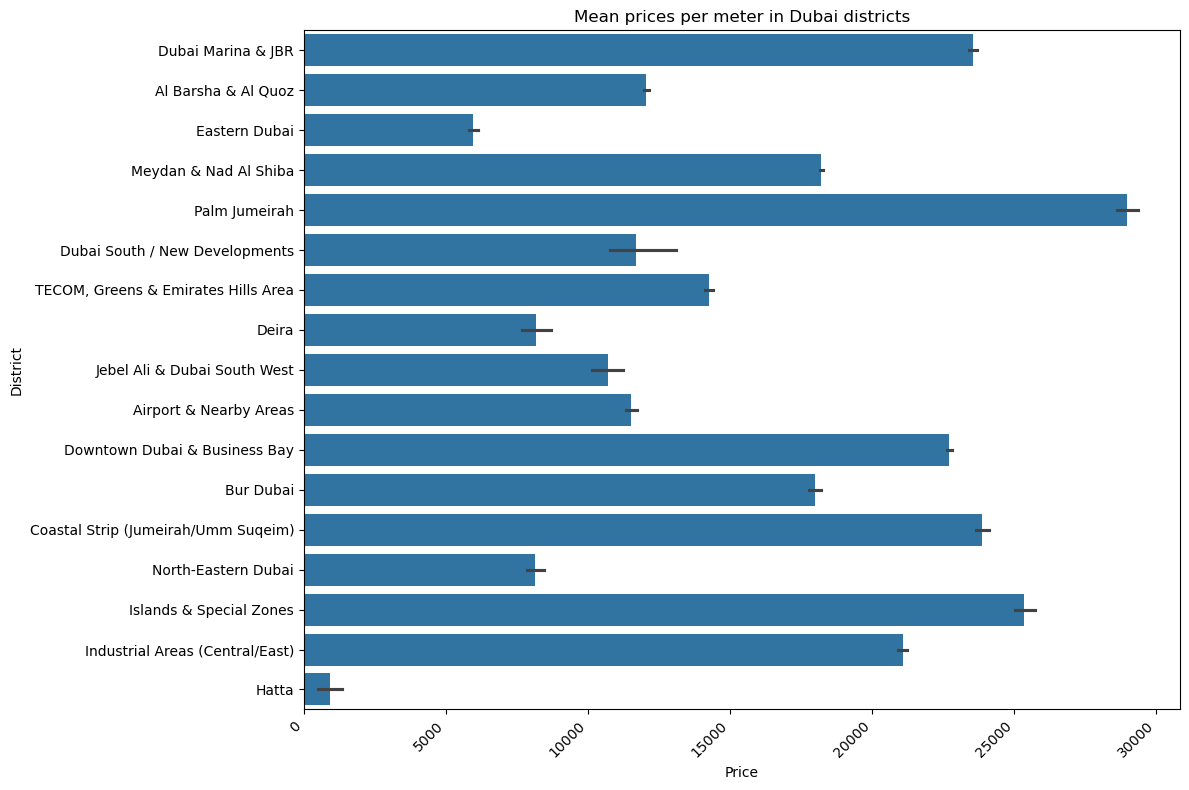

In [269]:
plt.figure(figsize=(12, 8))
sns.barplot(y=train_df_v9["district"], x=train_df_v9["target"])

plt.title("Mean prices per meter in Dubai districts")
plt.xlabel("Price")
plt.ylabel("District")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("fig6.png")
plt.show()

In [270]:
column_rules = [
    {"col": "target", "min_val": 500, "max_quant": 0.995},
    {"col": "procedure_area", "min_val": 20, "max_quant": 0.995},
    {"col": "actual_worth", "min_val": 50000, "max_quant": 0.995},
]
train_df_v9, test_df_v9 = remove_univariate_outliers(
    train_df_v9, test_df_v9, column_rules
)

TRAIN 'target': removed 3241 observations
TEST 'target': removed 872 observations
TRAIN 'procedure_area': removed 2424 observations
TEST 'procedure_area': removed 523 observations
TRAIN 'actual_worth': removed 2124 observations
TEST 'actual_worth': removed 553 observations


In [271]:
train_df_v9, test_df_v9 = remove_price_discrepancy_outliers(
    train_df_v9, test_df_v9, "target", "procedure_area", "actual_worth"
)

TRAIN 'price_diff': removed 18150 observations
TEST 'price_diff': removed 3074 observations


In [272]:
X_train_processed = train_df_v9.drop(
    [
        "procedure_name_en",
        "area_name_en",
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_train_log = train_df_v9["target"]
X_test_processed = test_df_v9.drop(
    [
        "procedure_name_en",
        "area_name_en",
        "actual_worth",
        "no_of_parties_role_1",
        "no_of_parties_role_2",
        "no_of_parties_role_3",
        "target",
    ],
    axis=1,
)
y_test_original = test_df_v9["target"]

In [273]:
X_train_v9, X_test_v9, y_train_v9, y_test_v9 = remove_feature_outliers_isoforest(
    X_train_processed,
    X_test_processed,
    y_train_log,
    y_test_original,
    numeric_cols_for_iso,
    contamination=0.02,
)

TRAIN (Isolation Forest): removed 7404 observations
TEST (Isolation Forest): removed 1288 observations


In [274]:
y_train_v9 = np.log1p(y_train_v9)

In [275]:
cat_features = [
    "trans_group_en",
    "property_type_en",
    "property_sub_type_en",
    "reg_type_en",
    "building_name_en",
    "project_name_en",
    "master_project_en",
    "nearest_landmark_en",
    "nearest_metro_en",
    "nearest_mall_en",
    "rooms_en",
    "has_parking",
    "year",
    "procedure_name_en_grouped",
    "district",
]

In [276]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v9,
#     y_train=y_train_v9,
#     X_test=X_test_v9,
#     y_test=y_test_v9,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [277]:
run_id = "7e129aad8a1b49e0abc9616fa5624f4b"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.22812640389706088,
 'test_r2': 0.6902200723024926,
 'test_rmse': 4852.261920068854,
 'test_mae': 3097.9494119539972,
 'train_rmse': 2908.3508645583843}

The results are better than those from the previous hypothesis after feature generation, but worse than those before aggregation. Unfortunately, the choice between interpretability of features and model performance must be made here. Aggregation seems necessary for the model's continued use in production, so it would be reasonable to maintain it.

### 10 Removing less important features

Based on SHAP, it is possible to identify some of the features that have a weak effect on targeting. In order to increase the interpretability of the model, it makes sense to try to remove the least important features from the dataset. 

In [281]:
X_train_v10 = X_train_v9.drop(
    [
        "nearest_landmark_en",
        "building_name_en",
        "nearest_metro_en",
        "nearest_mall_en",
        "property_sub_type_en",
        "has_parking",
        "year",
    ],
    axis=1,
)
X_test_v10 = X_test_v9.drop(
    [
        "nearest_landmark_en",
        "building_name_en",
        "nearest_metro_en",
        "nearest_mall_en",
        "property_sub_type_en",
        "has_parking",
        "year",
    ],
    axis=1,
)

In [282]:
cat_features = [
    "trans_group_en",
    "property_type_en",
    "reg_type_en",
    "project_name_en",
    "master_project_en",
    "rooms_en",
    "procedure_name_en_grouped",
    "district",
]

In [283]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v10,
#     y_train=y_train_v9,
#     X_test=X_test_v10,
#     y_test=y_test_v9,
#     cat_features=cat_features,
#     n_trials=15,
#     cv_splits_for_optuna=3
# )

In [284]:
run_id = "018906f26b1646f69fac48063335f738"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.26560426413031957,
 'test_r2': 0.7621708617461587,
 'test_rmse': 4251.577790308463,
 'test_mae': 2707.648133279988,
 'train_rmse': 3224.5410660724924}

The results improved again - without features such as “nearest metro”, “nearest mall”, “is there a parking lot nearby”, “property subtype” the model performed better, even taking into account the features aggregated in the previous step

### 11. Removing another less important features

It is possible to continue the logic of the previous hypothesis and further reduce the number of features to 8

In [288]:
X_train_v11 = X_train_v10.drop(["property_type_en", "rooms_en"], axis=1)
X_test_v11 = X_test_v10.drop(["property_type_en", "rooms_en"], axis=1)

In [289]:
cat_features = [
    "trans_group_en",
    "reg_type_en",
    "project_name_en",
    "master_project_en",
    "procedure_name_en_grouped",
    "district",
]

In [290]:
# final_model, y_pred_test = trainer.train_and_log_model(
#     X_train=X_train_v11,
#     y_train=y_train_v9,
#     X_test=X_test_v11,
#     y_test=y_test_v9,
#     cat_features=cat_features,
#     n_trials=50,
#     cv_splits_for_optuna=3
# )

In [291]:
run_id = "b5a4aea9774b44efaa0143a7f3134031"

run = mlflow.get_run(run_id)
run.data.metrics

{'optuna_best_cv_score_neg_rmse': 0.2400356837305194,
 'test_r2': 0.7777295362408007,
 'test_rmse': 4110.157615008324,
 'test_mae': 2496.2049114988895,
 'train_rmse': 3077.7932663228025}

The results of the model have improved even more, with only 8 key features now remaining in the dataset, and these can already be used to predict prices on new properties via Streamlit

## Export best model

The best model and the most numerous feature values can be uploaded for use in Streamlit

In [295]:
exporter = ModelExporter(
    experiment_name="Dubai_Property_CatBoost",
    model_run_name="dubai_catboost_v11",
    model_base_name="dubai_catboost",
)
exporter.export_model("dubai_model_streamlit.cbm")

Found run_id: b5a4aea9774b44efaa0143a7f3134031 for model name 'dubai_catboost_v11'
Model exported to: dubai_model_streamlit.cbm


In [296]:
with open("master_project_en.txt", "w", encoding="utf-8") as f:
    for item in X_train_v11["master_project_en"].unique():
        f.write(f"{item}\n")

In [297]:
with open("project_name_en.txt", "w", encoding="utf-8") as f:
    for item in X_train_v11["project_name_en"].unique():
        f.write(f"{item}\n")